In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:6'

FREERUN = 20
DT = .02

rho = 28.0
sigma = 10.0
beta = 8/3

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]
t = np.arange(0,300+FREERUN,DT)
states = odeint(f,state0,t)

muX = np.mean(states[:,0])
signal = states[:,0]-muX

M = signal.shape[0] - int(FREERUN/DT)
K = 1
L = 1
RF = .5
TEST = 1000
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST


MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
BINS = 50

print(f'Signal length M={M}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0
Signal length M=15000


In [2]:
np.save('./Targets/Xsignal',signal)

In [3]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [4]:
min_a, max_a = .25, .4
min_sr, max_sr = 1.25, 1.45
min_g, max_g = .8, 1.1
min_ri, max_ri = .001, 4.
min_rr, max_rr = .001, 4.
space = [Real(min_a, max_a, name='a'),
                 Real(min_sr, max_sr, name='sr'),
                 Real(min_g, max_g, name='amp'), 
                 Real(min_ri, max_ri, name='ri'),
                 Real(min_rr, max_rr, name='rr')
                ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,amp=1.0,ri=1.0,rr=1.0):
    start = time.time()
    global running_error, s, counter, signal, N, \
           alphas, rhos, gammas, inScales, resScales
    
    ut = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    tp = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                          device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype,
                          device=DEVICE)
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 

    state = states.detach().cpu().numpy()

    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE)
    torch.cuda.synchronize()

    predictions = torch.zeros((M+int(FREERUN/DT),1),
                              dtype=dtype,
                              device=torch.device(DEVICE))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+int(FREERUN/DT)):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST],
                          yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST],
                          MINMAX) 
    except:
        pass
    
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse + dist
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000
    
    if((loss < running_error) & (loss < .85)):
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.set_ylim(-25,25)
        ax1.legend()
        plt.show()
        fig.savefig(f'./X_Saved_Models/X_sz{N}_ref{ref}_run{rn}_iter{counter}.pdf',
                    format='pdf', bbox_inches='tight', pad_inches=.01)
        plt.close()
        
        np.save(f'./X_Saved_Models/X_it{counter}_{N}_{ref}_{rn}_Wnet',wnet)
        np.save(f'./X_Saved_Models/X_it{counter}_{N}_{ref}_{rn}_Preds',yHat_GPU)
        np.save(f'./X_Saved_Models/X_it{counter}_{N}_{ref}_{rn}_InstanceParams',currentParams)
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    ####### Running info ##############################
    print(f'Iter: {counter} #### Diagnostic {loss:3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {nrmse:.3f} CD {dist:.3f}')
    ###### Store this run #############################
    counter += 1
    return loss

********** Size 40 -- Run 0 ***********
Iter: 0 #### Diagnostic 1.301478   Time 8.21  Best 1000.000 NRMSE 0.302 CD 1.000
Iter: 1 #### Diagnostic 1000.000000   Time 3.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.380209   Time 3.90  Best 1000.000 NRMSE 0.313 CD 1.068
Iter: 3 #### Diagnostic 1.400429   Time 3.93  Best 1000.000 NRMSE 0.336 CD 1.065
Iter: 4 #### Diagnostic 1000.000000   Time 4.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.122393   Time 3.85  Best 1000.000 NRMSE 0.266 CD 0.856
Iter: 6 #### Diagnostic 0.908959   Time 3.85  Best 1000.000 NRMSE 0.242 CD 0.666
Iter: 7 #### Diagnostic 1.208492   Time 3.90  Best 1000.000 NRMSE 0.292 CD 0.917
Iter: 8 #### Diagnostic 1000.000000   Time 3.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.285043   Time 3.88  Best 1000.000 NRMSE 0.293 CD 0.992
Iter: 10 #### Diagnostic 1.369490   Time 4.00  Best 1000.000 NRMSE 0.299 CD 1.070
Iter: 11 #### Diagnostic 1000.000000   Time 4.01  Best 1

Iter: 99 #### Diagnostic 1.097122   Time 3.85  Best 1000.000 NRMSE 0.285 CD 0.812

Best result = 0.9089594094332591
a = 0.3431923238724236
sr = 1.3384944986072915
amp = 1.0692989228711967
ri = 0.27730213446902385
rr = 2.026195125724826
********** Size 40 -- Run 1 ***********
Iter: 0 #### Diagnostic 1.385982   Time 4.36  Best 1000.000 NRMSE 0.322 CD 1.064
Iter: 1 #### Diagnostic 1.388047   Time 4.25  Best 1000.000 NRMSE 0.316 CD 1.072
Iter: 2 #### Diagnostic 1.415350   Time 4.16  Best 1000.000 NRMSE 0.349 CD 1.066
Iter: 3 #### Diagnostic 1000.000000   Time 4.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.367057   Time 3.97  Best 1000.000 NRMSE 0.305 CD 1.062
Iter: 6 #### Diagnostic 1.386637   Time 4.09  Best 1000.000 NRMSE 0.325 CD 1.062
Iter: 7 #### Diagnostic 1.376366   Time 4.01  Best 1000.000 NRMSE 0.306 CD 1.071
Iter: 8 #### Diagnostic 1.311590   Time 4.14  Best 1000.000 NRMSE 0.

Iter: 96 #### Diagnostic 1.136008   Time 3.99  Best 1000.000 NRMSE 0.276 CD 0.860
Iter: 97 #### Diagnostic 1.427846   Time 4.69  Best 1000.000 NRMSE 0.309 CD 1.119
Iter: 98 #### Diagnostic 1.376021   Time 5.44  Best 1000.000 NRMSE 0.316 CD 1.060
Iter: 99 #### Diagnostic 1000.000000   Time 5.47  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.8823472132461152
a = 0.3352122937149499
sr = 1.3304814279001642
amp = 1.0458301513369581
ri = 0.8255666805427543
rr = 2.9779026727991176
********** Size 40 -- Run 2 ***********
Iter: 0 #### Diagnostic 1.231026   Time 5.55  Best 1000.000 NRMSE 0.284 CD 0.947
Iter: 1 #### Diagnostic 1000.000000   Time 5.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.214682   Time 5.59  Best 1000.000 NRMSE 0.283 CD 0.932
Iter: 3 #### Diagnostic 1000.000000   Time 5.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.342472   Time 5.46  Best 1000.000 NRMSE 0.304 CD 1.038
Iter: 5 #### Diagnostic 1.104797   Time 4.76  Best 1000.000 N

Iter: 93 #### Diagnostic 1.403161   Time 5.44  Best 1000.000 NRMSE 0.339 CD 1.064
Iter: 94 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1.375498   Time 5.48  Best 1000.000 NRMSE 0.300 CD 1.075
Iter: 96 #### Diagnostic 1.315047   Time 5.47  Best 1000.000 NRMSE 0.339 CD 0.976
Iter: 97 #### Diagnostic 1.387834   Time 5.43  Best 1000.000 NRMSE 0.322 CD 1.065
Iter: 98 #### Diagnostic 1.090386   Time 5.30  Best 1000.000 NRMSE 0.285 CD 0.806
Iter: 99 #### Diagnostic 1000.000000   Time 5.06  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.8883596707612187
a = 0.2546393792066479
sr = 1.29641967785285
amp = 0.8038266472535108
ri = 1.0992752360717586
rr = 3.7677155283743975
********** Size 40 -- Run 3 ***********
Iter: 0 #### Diagnostic 1.356200   Time 4.29  Best 1000.000 NRMSE 0.312 CD 1.044
Iter: 1 #### Diagnostic 1000.000000   Time 4.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.391488   Time 5.62  Best 1000.000 

Iter: 89 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 3.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 3.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1.395034   Time 3.90  Best 1000.000 NRMSE 0.330 CD 1.065
Iter: 93 #### Diagnostic 1.399768   Time 3.86  Best 1000.000 NRMSE 0.330 CD 1.070
Iter: 94 #### Diagnostic 0.938776   Time 3.90  Best 1000.000 NRMSE 0.238 CD 0.701
Iter: 95 #### Diagnostic 0.968702   Time 3.87  Best 1000.000 NRMSE 0.247 CD 0.721
Iter: 96 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1.351241   Time 3.90  Best 1000.000 NRMSE 0.306 CD 1.045
Iter: 98 #### Diagnostic 1.322167   Time 3.96  Best 1000.000 NRMSE 0.295 CD 1.027
Iter: 99 #### Diagnostic 1.264912   Time 3.90  Best 1000.000 NRMSE 0.290 CD 0.975

Best result = 0.9291449816989998
a = 0.29489550910012907
sr = 1.2857863925509454


Iter: 86 #### Diagnostic 1.381551   Time 4.07  Best 1000.000 NRMSE 0.319 CD 1.062
Iter: 87 #### Diagnostic 1.298978   Time 4.11  Best 1000.000 NRMSE 0.302 CD 0.997
Iter: 88 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.280766   Time 3.97  Best 1000.000 NRMSE 0.280 CD 1.001
Iter: 90 #### Diagnostic 1.383796   Time 4.02  Best 1000.000 NRMSE 0.320 CD 1.063
Iter: 91 #### Diagnostic 1.185443   Time 3.94  Best 1000.000 NRMSE 0.279 CD 0.907
Iter: 92 #### Diagnostic 1.340718   Time 4.02  Best 1000.000 NRMSE 0.298 CD 1.043
Iter: 93 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1.068557   Time 3.93  Best 1000.000 NRMSE 0.266 CD 0.802
Iter: 95 #### Diagnostic 1.392262   Time 4.83  Best 1000.000 NRMSE 0.329 CD 1.064
Iter: 96 #### Diagnostic 1000.000000   Time 5.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 5.46  Best 1000.000 NRMSE 1000.000 CD nan


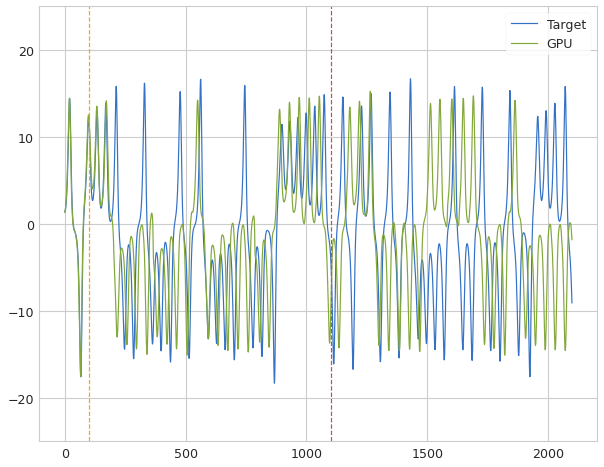

 Iter=76 a=0.340 sr=1.350 amp=0.967  ri=2.727 rr=2.505 loss=0.760725


Iter: 76 #### Diagnostic 0.760725   Time 4.74  Best 0.761 NRMSE 0.211 CD 0.549
Iter: 77 #### Diagnostic 1.376625   Time 3.96  Best 0.761 NRMSE 0.309 CD 1.068
Iter: 78 #### Diagnostic 1.365404   Time 3.90  Best 0.761 NRMSE 0.307 CD 1.058
Iter: 79 #### Diagnostic 1.133126   Time 3.90  Best 0.761 NRMSE 0.300 CD 0.833
Iter: 80 #### Diagnostic 1000.000000   Time 3.91  Best 0.761 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.190757   Time 3.93  Best 0.761 NRMSE 0.275 CD 0.916
Iter: 82 #### Diagnostic 1.233343   Time 3.92  Best 0.761 NRMSE 0.282 CD 0.951
Iter: 83 #### Diagnostic 1000.000000   Time 3.90  Best 0.761 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.404301   Time 3.94  Best 0.761 NRMSE 0.325 CD 1.080
Iter: 85 #### Diagnostic 1000.000000   Time 3.86  Best 0.761 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1.101479   Time 3.89  Best 0.761 NRMSE 0.271 CD 0.830
Iter: 87 #### Diagnostic 1.334972   Time 3.99  B

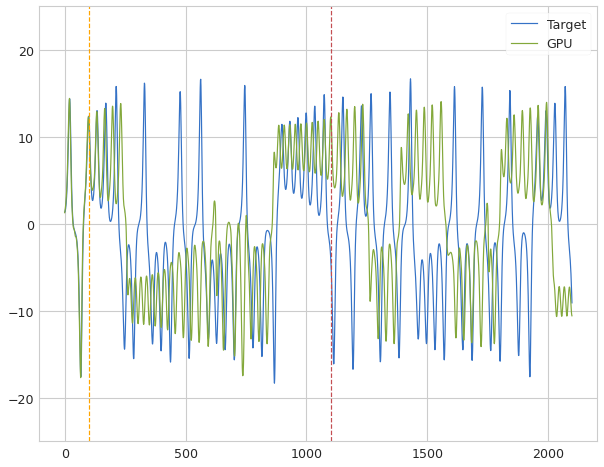

 Iter=37 a=0.278 sr=1.364 amp=1.089  ri=2.419 rr=1.743 loss=0.740645


Iter: 37 #### Diagnostic 0.740645   Time 5.04  Best 0.741 NRMSE 0.216 CD 0.525
Iter: 38 #### Diagnostic 1000.000000   Time 5.20  Best 0.741 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.358516   Time 5.38  Best 0.741 NRMSE 0.303 CD 1.056
Iter: 40 #### Diagnostic 1.329051   Time 5.48  Best 0.741 NRMSE 0.290 CD 1.039
Iter: 41 #### Diagnostic 1.406974   Time 5.81  Best 0.741 NRMSE 0.333 CD 1.074
Iter: 42 #### Diagnostic 1.356807   Time 5.63  Best 0.741 NRMSE 0.308 CD 1.049
Iter: 43 #### Diagnostic 1.373648   Time 5.54  Best 0.741 NRMSE 0.311 CD 1.063
Iter: 44 #### Diagnostic 1.310861   Time 5.50  Best 0.741 NRMSE 0.304 CD 1.006
Iter: 45 #### Diagnostic 1.409567   Time 4.81  Best 0.741 NRMSE 0.300 CD 1.110
Iter: 46 #### Diagnostic 1000.000000   Time 4.26  Best 0.741 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1.064016   Time 3.85  Best 0.741 NRMSE 0.264 CD 0.800
Iter: 48 #### Diagnostic 1000.000000   Time 3.90  Be

Iter: 36 #### Diagnostic 1.392704   Time 3.89  Best 1000.000 NRMSE 0.319 CD 1.074
Iter: 37 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.353310   Time 3.89  Best 1000.000 NRMSE 0.293 CD 1.061
Iter: 40 #### Diagnostic 1.385844   Time 4.02  Best 1000.000 NRMSE 0.329 CD 1.057
Iter: 41 #### Diagnostic 1.410567   Time 3.98  Best 1000.000 NRMSE 0.315 CD 1.095
Iter: 42 #### Diagnostic 1.435861   Time 4.86  Best 1000.000 NRMSE 0.307 CD 1.129
Iter: 43 #### Diagnostic 1.417784   Time 4.99  Best 1000.000 NRMSE 0.349 CD 1.069
Iter: 44 #### Diagnostic 1.361590   Time 3.97  Best 1000.000 NRMSE 0.301 CD 1.061
Iter: 45 #### Diagnostic 1.300637   Time 3.98  Best 1000.000 NRMSE 0.296 CD 1.005
Iter: 46 #### Diagnostic 1.230280   Time 3.90  Best 1000.000 NRMSE 0.282 CD 0.948
Iter: 47 #### Diagnostic 1.399302   Time 3.99  Best 1000.000 NRMSE 0.313 CD 1.087
Iter: 48

Iter: 33 #### Diagnostic 1.413967   Time 3.93  Best 1000.000 NRMSE 0.344 CD 1.070
Iter: 34 #### Diagnostic 1.400727   Time 3.92  Best 1000.000 NRMSE 0.324 CD 1.077
Iter: 35 #### Diagnostic 1.379934   Time 3.96  Best 1000.000 NRMSE 0.321 CD 1.059
Iter: 36 #### Diagnostic 1.179537   Time 3.90  Best 1000.000 NRMSE 0.298 CD 0.881
Iter: 37 #### Diagnostic 1.140502   Time 3.95  Best 1000.000 NRMSE 0.272 CD 0.869
Iter: 38 #### Diagnostic 1.390449   Time 3.94  Best 1000.000 NRMSE 0.302 CD 1.089
Iter: 39 #### Diagnostic 1000.000000   Time 4.00  Best 1000.000 NRMSE 91515651851933158696258442887168.000 CD 1.000
Iter: 40 #### Diagnostic 1.374547   Time 4.04  Best 1000.000 NRMSE 0.318 CD 1.056
Iter: 41 #### Diagnostic 1.400917   Time 3.93  Best 1000.000 NRMSE 0.336 CD 1.065
Iter: 42 #### Diagnostic 1.145183   Time 4.02  Best 1000.000 NRMSE 0.270 CD 0.875
Iter: 43 #### Diagnostic 1.662663   Time 3.95  Best 1000.000 NRMSE 0.713 CD 0.949
Iter: 44 #### Diagnostic 1.344764   Time 4.55  Best 1000.000 NRM

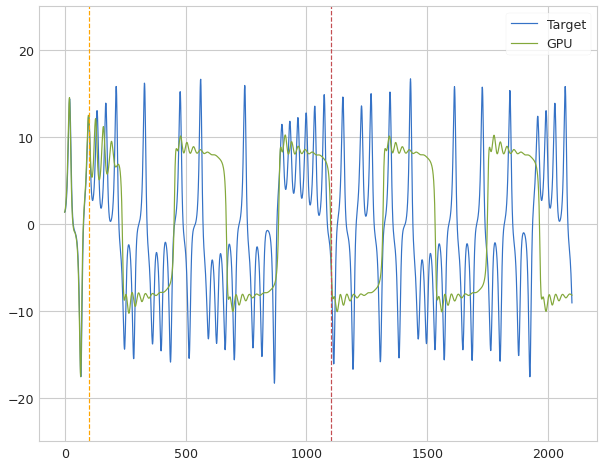

 Iter=85 a=0.250 sr=1.345 amp=1.026  ri=2.187 rr=2.425 loss=0.772035


Iter: 85 #### Diagnostic 0.772035   Time 4.59  Best 0.772 NRMSE 0.220 CD 0.552
Iter: 86 #### Diagnostic 1.390839   Time 5.56  Best 0.772 NRMSE 0.331 CD 1.059
Iter: 87 #### Diagnostic 1000.000000   Time 5.45  Best 0.772 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1.374110   Time 5.45  Best 0.772 NRMSE 0.306 CD 1.068
Iter: 89 #### Diagnostic 0.953888   Time 4.79  Best 0.772 NRMSE 0.250 CD 0.704
Iter: 90 #### Diagnostic 1.312891   Time 3.97  Best 0.772 NRMSE 0.292 CD 1.021
Iter: 91 #### Diagnostic 1.395474   Time 3.95  Best 0.772 NRMSE 0.324 CD 1.072
Iter: 92 #### Diagnostic 1.406368   Time 4.77  Best 0.772 NRMSE 0.326 CD 1.081
Iter: 93 #### Diagnostic 1.274144   Time 4.38  Best 0.772 NRMSE 0.290 CD 0.984
Iter: 94 #### Diagnostic 1.389642   Time 3.88  Best 0.772 NRMSE 0.330 CD 1.060
Iter: 95 #### Diagnostic 1.357303   Time 3.86  Best 0.772 NRMSE 0.301 CD 1.056
Iter: 96 #### Diagnostic 1.390094   Time 3.96  Best 0.77

Iter: 82 #### Diagnostic 1.401586   Time 4.05  Best 1000.000 NRMSE 0.339 CD 1.062
Iter: 83 #### Diagnostic 1.086754   Time 3.99  Best 1000.000 NRMSE 0.274 CD 0.813
Iter: 84 #### Diagnostic 1.398550   Time 4.17  Best 1000.000 NRMSE 0.330 CD 1.069
Iter: 85 #### Diagnostic 1000.000000   Time 4.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 3.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1.352021   Time 3.97  Best 1000.000 NRMSE 0.291 CD 1.061
Iter: 88 #### Diagnostic 1.403820   Time 3.95  Best 1000.000 NRMSE 0.338 CD 1.066
Iter: 89 #### Diagnostic 1.394289   Time 4.01  Best 1000.000 NRMSE 0.337 CD 1.057
Iter: 90 #### Diagnostic 1.398795   Time 3.94  Best 1000.000 NRMSE 0.335 CD 1.064
Iter: 91 #### Diagnostic 1.386127   Time 4.02  Best 1000.000 NRMSE 0.335 CD 1.052
Iter: 92 #### Diagnostic 1.398996   Time 6.29  Best 1000.000 NRMSE 0.335 CD 1.064
Iter: 93 #### Diagnostic 1.410329   Time 4.48  Best 1000.000 NRMSE 0.292 CD 1.118
Iter: 94

Iter: 72 #### Diagnostic 1.312703   Time 3.99  Best 1000.000 NRMSE 0.292 CD 1.021
Iter: 73 #### Diagnostic 1.295505   Time 4.01  Best 1000.000 NRMSE 0.287 CD 1.009
Iter: 74 #### Diagnostic 1.320909   Time 4.14  Best 1000.000 NRMSE 0.293 CD 1.028
Iter: 75 #### Diagnostic 1.331130   Time 4.00  Best 1000.000 NRMSE 0.292 CD 1.039
Iter: 76 #### Diagnostic 1.393424   Time 3.90  Best 1000.000 NRMSE 0.328 CD 1.065
Iter: 77 #### Diagnostic 1.384820   Time 3.82  Best 1000.000 NRMSE 0.319 CD 1.065
Iter: 78 #### Diagnostic 1.378326   Time 3.91  Best 1000.000 NRMSE 0.318 CD 1.061
Iter: 79 #### Diagnostic 1.326527   Time 3.97  Best 1000.000 NRMSE 0.301 CD 1.026
Iter: 80 #### Diagnostic 1.391045   Time 3.87  Best 1000.000 NRMSE 0.326 CD 1.065
Iter: 81 #### Diagnostic 1.315179   Time 4.01  Best 1000.000 NRMSE 0.289 CD 1.026
Iter: 82 #### Diagnostic 1.155444   Time 3.91  Best 1000.000 NRMSE 0.276 CD 0.879
Iter: 83 #### Diagnostic 1.371786   Time 3.88  Best 1000.000 NRMSE 0.315 CD 1.057
Iter: 84 #### Di

Iter: 69 #### Diagnostic 1.270957   Time 3.89  Best 1000.000 NRMSE 0.285 CD 0.986
Iter: 70 #### Diagnostic 1.370200   Time 3.82  Best 1000.000 NRMSE 0.311 CD 1.059
Iter: 71 #### Diagnostic 1.395640   Time 3.91  Best 1000.000 NRMSE 0.331 CD 1.065
Iter: 72 #### Diagnostic 0.968085   Time 3.92  Best 1000.000 NRMSE 0.254 CD 0.715
Iter: 73 #### Diagnostic 1.412294   Time 4.04  Best 1000.000 NRMSE 0.326 CD 1.087
Iter: 74 #### Diagnostic 1.166821   Time 4.29  Best 1000.000 NRMSE 0.279 CD 0.888
Iter: 75 #### Diagnostic 1.402875   Time 3.87  Best 1000.000 NRMSE 0.337 CD 1.066
Iter: 76 #### Diagnostic 1.368292   Time 3.88  Best 1000.000 NRMSE 0.304 CD 1.064
Iter: 77 #### Diagnostic 1.417756   Time 3.92  Best 1000.000 NRMSE 0.308 CD 1.109
Iter: 78 #### Diagnostic 1.372004   Time 3.85  Best 1000.000 NRMSE 0.323 CD 1.049
Iter: 79 #### Diagnostic 1.382064   Time 3.83  Best 1000.000 NRMSE 0.319 CD 1.063
Iter: 80 #### Diagnostic 1.305373   Time 4.01  Best 1000.000 NRMSE 0.298 CD 1.008
Iter: 81 #### Di

Iter: 66 #### Diagnostic 1.386253   Time 3.93  Best 1000.000 NRMSE 0.322 CD 1.064
Iter: 67 #### Diagnostic 1.392347   Time 3.97  Best 1000.000 NRMSE 0.329 CD 1.063
Iter: 68 #### Diagnostic 1000.000000   Time 4.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.074404   Time 4.01  Best 1000.000 NRMSE 0.208 CD 0.866
Iter: 70 #### Diagnostic 1.041383   Time 4.11  Best 1000.000 NRMSE 0.247 CD 0.794
Iter: 71 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.293174   Time 4.10  Best 1000.000 NRMSE 0.289 CD 1.004
Iter: 73 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1.380472   Time 3.95  Best 1000.000 NRMSE 0.321 CD 1.059
Iter: 75 #### Diagnostic 1.387247   Time 3.90  Best 1000.000 NRMSE 0.324 CD 1.064
Iter: 76 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.266015   Time 4.00  Best 1000.000 NRMSE 0.282 CD 0.984


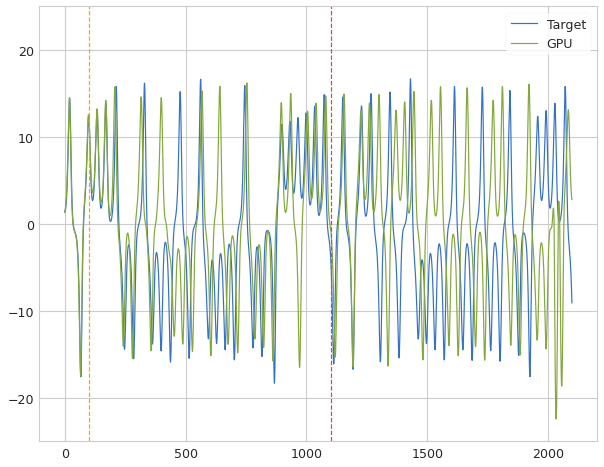

 Iter=97 a=0.318 sr=1.329 amp=0.897  ri=1.900 rr=3.468 loss=0.699197


Iter: 97 #### Diagnostic 0.699197   Time 6.00  Best 0.699 NRMSE 0.206 CD 0.493
Iter: 98 #### Diagnostic 1.288061   Time 4.09  Best 0.699 NRMSE 0.293 CD 0.996
Iter: 99 #### Diagnostic 1.376024   Time 4.10  Best 0.699 NRMSE 0.314 CD 1.062

Best result = 0.699196763551799
a = 0.3183895486255522
sr = 1.3293799328274651
amp = 0.8971502274612355
ri = 1.9003524169474342
rr = 3.4681659432347574
********** Size 40 -- Run 3 ***********
Iter: 0 #### Diagnostic 1.362904   Time 4.16  Best 1000.000 NRMSE 0.300 CD 1.063
Iter: 1 #### Diagnostic 1.361428   Time 3.99  Best 1000.000 NRMSE 0.311 CD 1.051
Iter: 2 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1.281848   Time 3.92  Best 1000.000 NRMSE 0.294 CD 0.988
Iter: 4 #### Diagnostic 1.386027   Time 3.91  Best 1000.000 NRMSE 0.321 CD 1.065
Iter: 5 #### Diagnostic 1.396933   Time 4.35  Best 1000.000 NRMSE 0.329 CD 1.068
Iter: 6 #

Iter: 93 #### Diagnostic 1.385424   Time 5.40  Best 1000.000 NRMSE 0.324 CD 1.061
Iter: 94 #### Diagnostic 1.334696   Time 5.71  Best 1000.000 NRMSE 0.296 CD 1.038
Iter: 95 #### Diagnostic 1.441105   Time 6.92  Best 1000.000 NRMSE 0.311 CD 1.131
Iter: 96 #### Diagnostic 1.376118   Time 6.80  Best 1000.000 NRMSE 0.312 CD 1.065
Iter: 97 #### Diagnostic 1.402627   Time 5.74  Best 1000.000 NRMSE 0.335 CD 1.067
Iter: 98 #### Diagnostic 1.406218   Time 5.42  Best 1000.000 NRMSE 0.336 CD 1.070
Iter: 99 #### Diagnostic 1.321469   Time 8.77  Best 1000.000 NRMSE 0.288 CD 1.034

Best result = 0.9130598613530677
a = 0.2782390394887544
sr = 1.3223329273525182
amp = 1.0812748317450604
ri = 0.28275674736078377
rr = 2.1376404169440857
********** Size 40 -- Run 4 ***********
Iter: 0 #### Diagnostic 1.372586   Time 7.89  Best 1000.000 NRMSE 0.311 CD 1.062
Iter: 1 #### Diagnostic 1.356721   Time 6.09  Best 1000.000 NRMSE 0.299 CD 1.058
Iter: 2 #### Diagnostic 1.359235   Time 6.96  Best 1000.000 NRMSE 0.3

Iter: 90 #### Diagnostic 1.194616   Time 3.87  Best 1000.000 NRMSE 0.265 CD 0.930
Iter: 91 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1.364957   Time 3.89  Best 1000.000 NRMSE 0.308 CD 1.057
Iter: 93 #### Diagnostic 1.442250   Time 3.92  Best 1000.000 NRMSE 0.306 CD 1.136
Iter: 94 #### Diagnostic 1.394499   Time 3.93  Best 1000.000 NRMSE 0.330 CD 1.065
Iter: 95 #### Diagnostic 1000.000000   Time 4.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1.415008   Time 4.73  Best 1000.000 NRMSE 0.315 CD 1.100
Iter: 97 #### Diagnostic 1000.000000   Time 5.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1.447879   Time 3.95  Best 1000.000 NRMSE 0.320 CD 1.128

Best result = 0.996739843165896
a = 0.29746477772405894
sr = 1.2523554311679113
amp = 1.0508566939696733
ri = 0.04655699204829299
rr = 0.3134134862253275

Best mn:

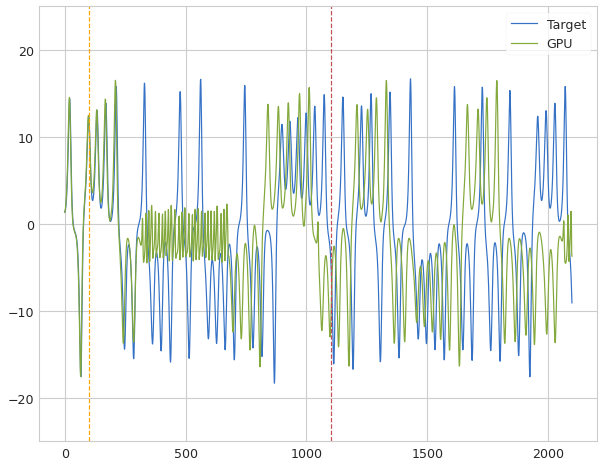

 Iter=7 a=0.320 sr=1.386 amp=0.946  ri=1.709 rr=1.594 loss=0.778019


Iter: 7 #### Diagnostic 0.778019   Time 4.25  Best 0.778 NRMSE 0.203 CD 0.575
Iter: 8 #### Diagnostic 1.357132   Time 3.87  Best 0.778 NRMSE 0.308 CD 1.049
Iter: 9 #### Diagnostic 1.155539   Time 3.91  Best 0.778 NRMSE 0.279 CD 0.877
Iter: 10 #### Diagnostic 1.019329   Time 3.96  Best 0.778 NRMSE 0.257 CD 0.762
Iter: 11 #### Diagnostic 1.361578   Time 4.31  Best 0.778 NRMSE 0.318 CD 1.044
Iter: 12 #### Diagnostic 1000.000000   Time 4.04  Best 0.778 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.369931   Time 4.43  Best 0.778 NRMSE 0.312 CD 1.058
Iter: 14 #### Diagnostic 1.560287   Time 3.93  Best 0.778 NRMSE 0.333 CD 1.227
Iter: 15 #### Diagnostic 1.363977   Time 4.01  Best 0.778 NRMSE 0.302 CD 1.062
Iter: 16 #### Diagnostic 1.358776   Time 3.93  Best 0.778 NRMSE 0.317 CD 1.042
Iter: 17 #### Diagnostic 1.371184   Time 3.85  Best 0.778 NRMSE 0.305 CD 1.066
Iter: 18 #### Diagnostic 1.407830   Time 4.00  Best 0.778 NR

Iter: 7 #### Diagnostic 1.344473   Time 6.01  Best 1000.000 NRMSE 0.318 CD 1.027
Iter: 8 #### Diagnostic 1.352518   Time 6.26  Best 1000.000 NRMSE 0.290 CD 1.062
Iter: 9 #### Diagnostic 0.918589   Time 5.81  Best 1000.000 NRMSE 0.207 CD 0.712
Iter: 10 #### Diagnostic 1.327724   Time 6.31  Best 1000.000 NRMSE 0.297 CD 1.030
Iter: 11 #### Diagnostic 1.374070   Time 5.97  Best 1000.000 NRMSE 0.319 CD 1.055
Iter: 12 #### Diagnostic 1000.000000   Time 6.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.196714   Time 5.04  Best 1000.000 NRMSE 0.280 CD 0.917
Iter: 14 #### Diagnostic 1.215523   Time 4.69  Best 1000.000 NRMSE 0.288 CD 0.928
Iter: 15 #### Diagnostic 0.974970   Time 5.28  Best 1000.000 NRMSE 0.250 CD 0.725
Iter: 16 #### Diagnostic 1.270481   Time 4.74  Best 1000.000 NRMSE 0.287 CD 0.984
Iter: 17 #### Diagnostic 1000.000000   Time 4.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 5.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1

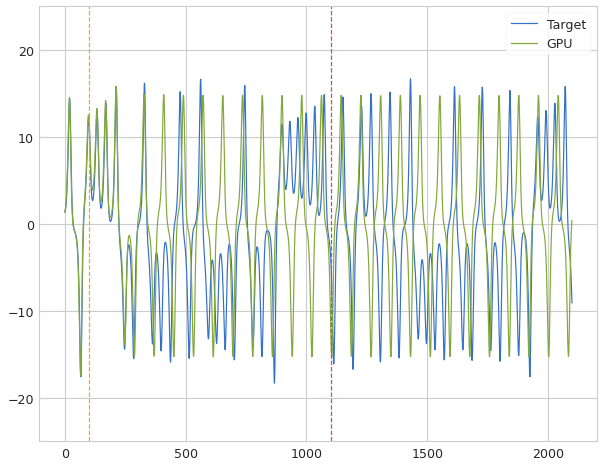

 Iter=48 a=0.374 sr=1.320 amp=0.825  ri=1.896 rr=2.318 loss=0.825815


Iter: 48 #### Diagnostic 0.825815   Time 5.31  Best 0.826 NRMSE 0.224 CD 0.602
Iter: 49 #### Diagnostic 1000.000000   Time 4.79  Best 0.826 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 6.36  Best 0.826 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.348757   Time 5.27  Best 0.826 NRMSE 0.290 CD 1.059
Iter: 52 #### Diagnostic 1.289463   Time 6.67  Best 0.826 NRMSE 0.294 CD 0.996
Iter: 53 #### Diagnostic 1.390462   Time 6.03  Best 0.826 NRMSE 0.312 CD 1.078
Iter: 54 #### Diagnostic 1.294453   Time 5.28  Best 0.826 NRMSE 0.285 CD 1.009
Iter: 55 #### Diagnostic 1.445614   Time 5.57  Best 0.826 NRMSE 0.315 CD 1.130
Iter: 56 #### Diagnostic 1.395644   Time 5.33  Best 0.826 NRMSE 0.332 CD 1.063
Iter: 57 #### Diagnostic 1.408032   Time 5.15  Best 0.826 NRMSE 0.343 CD 1.065
Iter: 58 #### Diagnostic 1.074216   Time 5.07  Best 0.826 NRMSE 0.257 CD 0.818
Iter: 59 #### Diagnostic 1000.000000   Time 5.65  Be

Iter: 46 #### Diagnostic 1.248655   Time 5.19  Best 1000.000 NRMSE 0.276 CD 0.973
Iter: 47 #### Diagnostic 1000.000000   Time 4.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.388080   Time 5.22  Best 1000.000 NRMSE 0.319 CD 1.069
Iter: 49 #### Diagnostic 1000.000000   Time 5.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 5.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.203796   Time 4.78  Best 1000.000 NRMSE 0.282 CD 0.921
Iter: 52 #### Diagnostic 1000.000000   Time 5.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 5.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.248045   Time 4.74  Best 1000.000 NRMSE 0.275 CD 0.973
Iter: 55 #### Diagnostic 1.338766   Time 5.18  Best 1000.000 NRMSE 0.301 CD 1.038
Iter: 56 #### Diagnostic 1.429621   Time 4.67  Best 1000.000 NRMSE 0.307 CD 1.122
Iter: 57 #### Diagnostic 1.371412   Time 4.38  Best 1000.000 NRMSE 0.310 CD 1.

Iter: 43 #### Diagnostic 1.296392   Time 4.87  Best 1000.000 NRMSE 0.290 CD 1.006
Iter: 44 #### Diagnostic 1.254461   Time 5.43  Best 1000.000 NRMSE 0.288 CD 0.966
Iter: 45 #### Diagnostic 1.381522   Time 4.88  Best 1000.000 NRMSE 0.318 CD 1.063
Iter: 46 #### Diagnostic 1.053306   Time 5.77  Best 1000.000 NRMSE 0.263 CD 0.791
Iter: 47 #### Diagnostic 1000.000000   Time 4.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 5.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 5.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.215780   Time 4.99  Best 1000.000 NRMSE 0.282 CD 0.933
Iter: 51 #### Diagnostic 1.251093   Time 4.83  Best 1000.000 NRMSE 0.283 CD 0.968
Iter: 52 #### Diagnostic 1.390565   Time 5.62  Best 1000.000 NRMSE 0.326 CD 1.064
Iter: 53 #### Diagnostic 1.322358   Time 5.78  Best 1000.000 NRMSE 0.302 CD 1.021
Iter: 54 #### Diagnostic 1.383967   Time 5.71  Best 1000.000 NRMSE 0.321 CD 1.063
Iter

Iter: 40 #### Diagnostic 1.402007   Time 6.39  Best 1000.000 NRMSE 0.336 CD 1.066
Iter: 41 #### Diagnostic 1.149576   Time 4.81  Best 1000.000 NRMSE 0.289 CD 0.861
Iter: 42 #### Diagnostic 1.375399   Time 5.21  Best 1000.000 NRMSE 0.313 CD 1.062
Iter: 43 #### Diagnostic 1.128464   Time 5.61  Best 1000.000 NRMSE 0.259 CD 0.870
Iter: 44 #### Diagnostic 1.393918   Time 4.45  Best 1000.000 NRMSE 0.327 CD 1.067
Iter: 45 #### Diagnostic 1.408328   Time 4.77  Best 1000.000 NRMSE 0.343 CD 1.065
Iter: 46 #### Diagnostic 1.220024   Time 5.45  Best 1000.000 NRMSE 0.272 CD 0.948
Iter: 47 #### Diagnostic 1.291684   Time 5.57  Best 1000.000 NRMSE 0.269 CD 1.022
Iter: 48 #### Diagnostic 1.399259   Time 4.79  Best 1000.000 NRMSE 0.330 CD 1.069
Iter: 49 #### Diagnostic 1.328042   Time 5.57  Best 1000.000 NRMSE 0.328 CD 1.000
Iter: 50 #### Diagnostic 1.341762   Time 5.44  Best 1000.000 NRMSE 0.297 CD 1.045
Iter: 51 #### Diagnostic 1000.000000   Time 5.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 ###

Iter: 30 #### Diagnostic 1.385983   Time 5.13  Best 1000.000 NRMSE 0.331 CD 1.055
Iter: 31 #### Diagnostic 1.402826   Time 6.38  Best 1000.000 NRMSE 0.337 CD 1.066
Iter: 32 #### Diagnostic 1.424206   Time 4.99  Best 1000.000 NRMSE 0.332 CD 1.093
Iter: 33 #### Diagnostic 1.401727   Time 6.54  Best 1000.000 NRMSE 0.338 CD 1.063
Iter: 34 #### Diagnostic 1.087990   Time 5.40  Best 1000.000 NRMSE 0.265 CD 0.823
Iter: 35 #### Diagnostic 1.409528   Time 5.56  Best 1000.000 NRMSE 0.324 CD 1.085
Iter: 36 #### Diagnostic 1.366786   Time 5.22  Best 1000.000 NRMSE 0.320 CD 1.047
Iter: 37 #### Diagnostic 1.433928   Time 4.74  Best 1000.000 NRMSE 0.303 CD 1.131
Iter: 38 #### Diagnostic 1.368463   Time 5.91  Best 1000.000 NRMSE 0.321 CD 1.048
Iter: 39 #### Diagnostic 1.388609   Time 5.86  Best 1000.000 NRMSE 0.309 CD 1.080
Iter: 40 #### Diagnostic 1.215431   Time 6.50  Best 1000.000 NRMSE 0.244 CD 0.971
Iter: 41 #### Diagnostic 1.381007   Time 5.24  Best 1000.000 NRMSE 0.320 CD 1.061
Iter: 42 #### Di

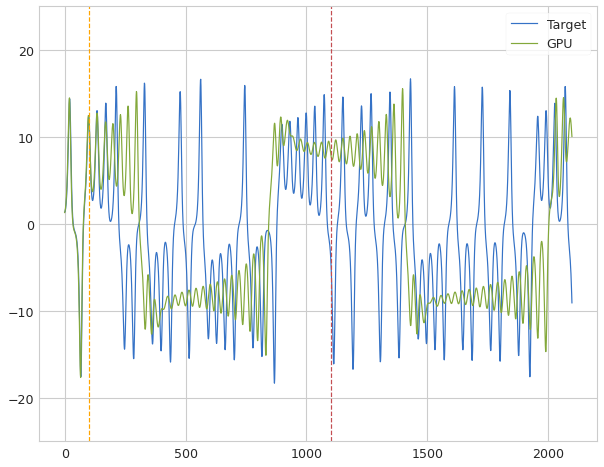

 Iter=54 a=0.277 sr=1.274 amp=0.895  ri=0.113 rr=2.343 loss=0.816281


Iter: 54 #### Diagnostic 0.816281   Time 5.90  Best 0.816 NRMSE 0.236 CD 0.581
Iter: 55 #### Diagnostic 1.068432   Time 5.12  Best 0.816 NRMSE 0.265 CD 0.804
Iter: 56 #### Diagnostic 1.394260   Time 4.66  Best 0.816 NRMSE 0.327 CD 1.067
Iter: 57 #### Diagnostic 1000.000000   Time 4.76  Best 0.816 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.412722   Time 5.70  Best 0.816 NRMSE 0.348 CD 1.065
Iter: 59 #### Diagnostic 1.037498   Time 4.92  Best 0.816 NRMSE 0.269 CD 0.768
Iter: 60 #### Diagnostic 1000.000000   Time 5.56  Best 0.816 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1.376428   Time 4.70  Best 0.816 NRMSE 0.311 CD 1.065
Iter: 62 #### Diagnostic 1000.000000   Time 6.77  Best 0.816 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.180046   Time 5.53  Best 0.816 NRMSE 0.270 CD 0.910
Iter: 64 #### Diagnostic 1.377825   Time 4.58  Best 0.816 NRMSE 0.317 CD 1.061
Iter: 65 #### Diagnostic 1.344543   Time 5.70  B

Iter: 52 #### Diagnostic 1.397110   Time 5.42  Best 1000.000 NRMSE 0.332 CD 1.066
Iter: 53 #### Diagnostic 1.289063   Time 4.71  Best 1000.000 NRMSE 0.286 CD 1.003
Iter: 54 #### Diagnostic 1.369872   Time 5.28  Best 1000.000 NRMSE 0.292 CD 1.078
Iter: 55 #### Diagnostic 1.393530   Time 6.27  Best 1000.000 NRMSE 0.328 CD 1.065
Iter: 56 #### Diagnostic 1.158016   Time 5.90  Best 1000.000 NRMSE 0.286 CD 0.872
Iter: 57 #### Diagnostic 1.381467   Time 5.59  Best 1000.000 NRMSE 0.321 CD 1.060
Iter: 58 #### Diagnostic 1.402023   Time 6.57  Best 1000.000 NRMSE 0.337 CD 1.065
Iter: 59 #### Diagnostic 1.399913   Time 5.27  Best 1000.000 NRMSE 0.330 CD 1.070
Iter: 60 #### Diagnostic 1.183517   Time 6.35  Best 1000.000 NRMSE 0.288 CD 0.895
Iter: 61 #### Diagnostic 1.080676   Time 6.32  Best 1000.000 NRMSE 0.263 CD 0.818
Iter: 62 #### Diagnostic 1.365674   Time 7.48  Best 1000.000 NRMSE 0.307 CD 1.058
Iter: 63 #### Diagnostic 1.331666   Time 10.55  Best 1000.000 NRMSE 0.291 CD 1.041
Iter: 64 #### D

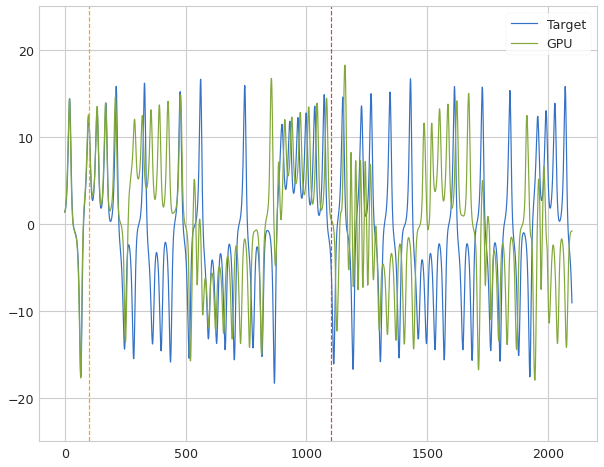

 Iter=79 a=0.263 sr=1.428 amp=1.054  ri=1.088 rr=3.427 loss=0.782397


Iter: 79 #### Diagnostic 0.782397   Time 10.08  Best 0.782 NRMSE 0.217 CD 0.565
Iter: 80 #### Diagnostic 1.379969   Time 7.94  Best 0.782 NRMSE 0.318 CD 1.062
Iter: 81 #### Diagnostic 1.468539   Time 6.69  Best 0.782 NRMSE 0.308 CD 1.160
Iter: 82 #### Diagnostic 1.331774   Time 10.75  Best 0.782 NRMSE 0.297 CD 1.034
Iter: 83 #### Diagnostic 1000.000000   Time 8.15  Best 0.782 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.364825   Time 8.36  Best 0.782 NRMSE 0.303 CD 1.062
Iter: 85 #### Diagnostic 0.973144   Time 8.96  Best 0.782 NRMSE 0.244 CD 0.730
Iter: 86 #### Diagnostic 1.386740   Time 9.43  Best 0.782 NRMSE 0.327 CD 1.059
Iter: 87 #### Diagnostic 1.389357   Time 10.25  Best 0.782 NRMSE 0.322 CD 1.067
Iter: 88 #### Diagnostic 1.569025   Time 7.31  Best 0.782 NRMSE 0.433 CD 1.136
Iter: 89 #### Diagnostic 1.383974   Time 9.69  Best 0.782 NRMSE 0.316 CD 1.068
Iter: 90 #### Diagnostic 1.049910   Time 9.30  Best 0

Iter: 76 #### Diagnostic 1.089777   Time 4.87  Best 1000.000 NRMSE 0.280 CD 0.810
Iter: 77 #### Diagnostic 1.000933   Time 5.59  Best 1000.000 NRMSE 0.258 CD 0.743
Iter: 78 #### Diagnostic 1.364163   Time 5.04  Best 1000.000 NRMSE 0.305 CD 1.059
Iter: 79 #### Diagnostic 1.164161   Time 5.51  Best 1000.000 NRMSE 0.276 CD 0.888
Iter: 80 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.260615   Time 5.34  Best 1000.000 NRMSE 0.288 CD 0.972
Iter: 82 #### Diagnostic 1000.000000   Time 4.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1.388802   Time 5.98  Best 1000.000 NRMSE 0.324 CD 1.065
Iter: 84 #### Diagnostic 1.449722   Time 5.18  Best 1000.000 NRMSE 0.311 CD 1.139
Iter: 85 #### Diagnostic 1.162055   Time 4.28  Best 1000.000 NRMSE 0.275 CD 0.887
Iter: 86 #### Diagnostic 1.397401   Time 7.13  Best 1000.000 NRMSE 0.323 CD 1.074
Iter: 87 #### Diagnostic 1000.000000   Time 5.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter

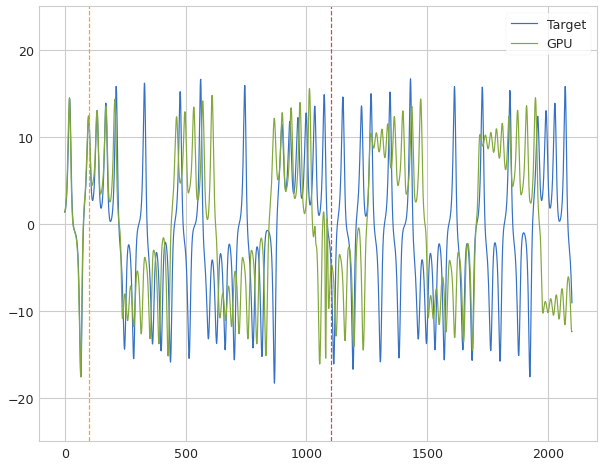

 Iter=94 a=0.318 sr=1.403 amp=1.055  ri=1.078 rr=3.843 loss=0.824331


Iter: 94 #### Diagnostic 0.824331   Time 5.34  Best 0.824 NRMSE 0.230 CD 0.595
Iter: 95 #### Diagnostic 1.072892   Time 4.91  Best 0.824 NRMSE 0.281 CD 0.792
Iter: 96 #### Diagnostic 1.438695   Time 4.37  Best 0.824 NRMSE 0.311 CD 1.128
Iter: 97 #### Diagnostic 1.415313   Time 5.33  Best 0.824 NRMSE 0.342 CD 1.073
Iter: 98 #### Diagnostic 1.207624   Time 4.55  Best 0.824 NRMSE 0.269 CD 0.939
Iter: 99 #### Diagnostic 1.267234   Time 5.17  Best 0.824 NRMSE 0.278 CD 0.989

Best result = 0.8243311134928102
a = 0.3177647474724588
sr = 1.4027614239059691
amp = 1.054612065499104
ri = 1.0777672062709165
rr = 3.8434960169998678
********** Size 40 -- Run 3 ***********
Iter: 0 #### Diagnostic 1.305674   Time 5.15  Best 1000.000 NRMSE 0.291 CD 1.015
Iter: 1 #### Diagnostic 1.385594   Time 6.44  Best 1000.000 NRMSE 0.327 CD 1.059
Iter: 2 #### Diagnostic 0.947205   Time 5.89  Best 1000.000 NRMSE 0.239 CD 0.708
Iter: 3 #### Diagno

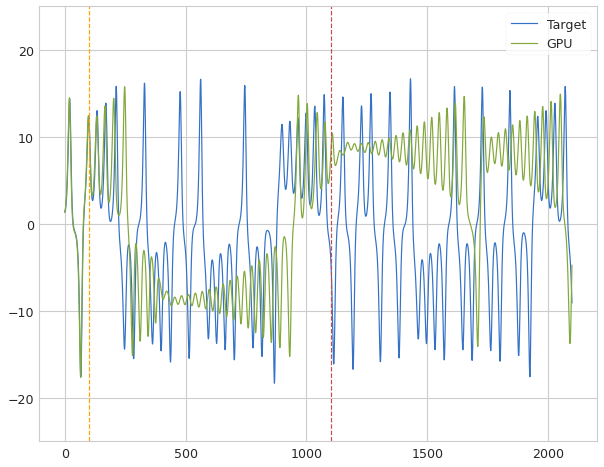

 Iter=12 a=0.315 sr=1.343 amp=1.013  ri=0.152 rr=2.076 loss=0.821215


Iter: 12 #### Diagnostic 0.821215   Time 6.38  Best 0.821 NRMSE 0.231 CD 0.590
Iter: 13 #### Diagnostic 1.378896   Time 5.92  Best 0.821 NRMSE 0.323 CD 1.056
Iter: 14 #### Diagnostic 1.355818   Time 5.29  Best 0.821 NRMSE 0.307 CD 1.049
Iter: 15 #### Diagnostic 1.013455   Time 5.63  Best 0.821 NRMSE 0.247 CD 0.767
Iter: 16 #### Diagnostic 1000.000000   Time 4.83  Best 0.821 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.367243   Time 5.90  Best 0.821 NRMSE 0.314 CD 1.054
Iter: 18 #### Diagnostic 1000.000000   Time 5.48  Best 0.821 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1.140605   Time 4.40  Best 0.821 NRMSE 0.268 CD 0.872
Iter: 20 #### Diagnostic 1000.000000   Time 5.21  Best 0.821 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1.314664   Time 4.68  Best 0.821 NRMSE 0.296 CD 1.018
Iter: 22 #### Diagnostic 0.869298   Time 5.74  Best 0.821 NRMSE 0.230 CD 0.640
Iter: 23 #### Diagnostic 1.395314   Time 6.19  B

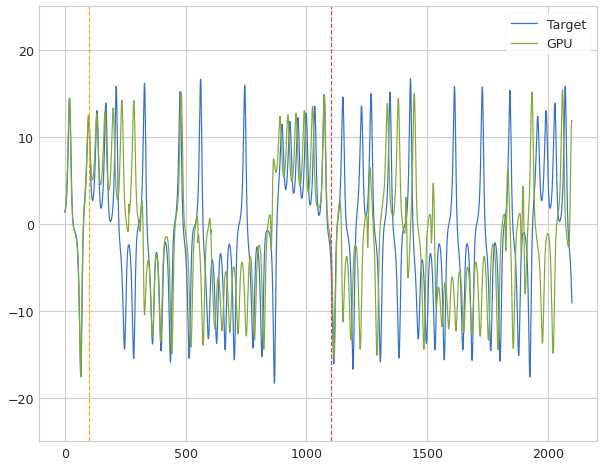

 Iter=37 a=0.393 sr=1.261 amp=0.889  ri=2.609 rr=3.682 loss=0.713339


Iter: 37 #### Diagnostic 0.713339   Time 5.74  Best 0.713 NRMSE 0.207 CD 0.507
Iter: 38 #### Diagnostic 1.388730   Time 6.00  Best 0.713 NRMSE 0.330 CD 1.059
Iter: 39 #### Diagnostic 1.322653   Time 4.96  Best 0.713 NRMSE 0.305 CD 1.017
Iter: 40 #### Diagnostic 1.134413   Time 7.28  Best 0.713 NRMSE 0.273 CD 0.862
Iter: 41 #### Diagnostic 1.408251   Time 5.15  Best 0.713 NRMSE 0.344 CD 1.065
Iter: 42 #### Diagnostic 1.044137   Time 4.47  Best 0.713 NRMSE 0.267 CD 0.777
Iter: 43 #### Diagnostic 1.368215   Time 5.82  Best 0.713 NRMSE 0.295 CD 1.073
Iter: 44 #### Diagnostic 1.185727   Time 4.70  Best 0.713 NRMSE 0.278 CD 0.908
Iter: 45 #### Diagnostic 1.064079   Time 5.16  Best 0.713 NRMSE 0.281 CD 0.783
Iter: 46 #### Diagnostic 1000.000000   Time 5.10  Best 0.713 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1.382799   Time 5.96  Best 0.713 NRMSE 0.314 CD 1.069
Iter: 48 #### Diagnostic 1000.000000   Time 5.60  Best 0

Iter: 36 #### Diagnostic 1000.000000   Time 5.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.392572   Time 4.67  Best 1000.000 NRMSE 0.337 CD 1.055
Iter: 38 #### Diagnostic 1000.000000   Time 5.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.361359   Time 4.65  Best 1000.000 NRMSE 0.306 CD 1.056
Iter: 40 #### Diagnostic 1.245400   Time 5.60  Best 1000.000 NRMSE 0.291 CD 0.954
Iter: 41 #### Diagnostic 1.338576   Time 5.59  Best 1000.000 NRMSE 0.298 CD 1.040
Iter: 42 #### Diagnostic 1.403377   Time 5.94  Best 1000.000 NRMSE 0.328 CD 1.076
Iter: 43 #### Diagnostic 1.382235   Time 5.33  Best 1000.000 NRMSE 0.321 CD 1.062
Iter: 44 #### Diagnostic 1.062929   Time 4.64  Best 1000.000 NRMSE 0.260 CD 0.803
Iter: 45 #### Diagnostic 1.113260   Time 4.65  Best 1000.000 NRMSE 0.268 CD 0.845
Iter: 46 #### Diagnostic 1.402972   Time 4.38  Best 1000.000 NRMSE 0.336 CD 1.067
Iter: 47 #### Diagnostic 1.419158   Time 5.67  Best 1000.000 NRMSE 0.306 CD 1.113
Iter: 48

Iter: 26 #### Diagnostic 1.389417   Time 5.47  Best 1000.000 NRMSE 0.297 CD 1.092
Iter: 27 #### Diagnostic 1.121496   Time 4.18  Best 1000.000 NRMSE 0.267 CD 0.854
Iter: 28 #### Diagnostic 1.371051   Time 5.34  Best 1000.000 NRMSE 0.313 CD 1.058
Iter: 29 #### Diagnostic 1.204194   Time 4.96  Best 1000.000 NRMSE 0.274 CD 0.930
Iter: 30 #### Diagnostic 1.165988   Time 4.73  Best 1000.000 NRMSE 0.275 CD 0.891
Iter: 31 #### Diagnostic 1.439289   Time 4.73  Best 1000.000 NRMSE 0.321 CD 1.118
Iter: 32 #### Diagnostic 1000.000000   Time 4.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1.391950   Time 4.90  Best 1000.000 NRMSE 0.329 CD 1.063
Iter: 34 #### Diagnostic 1.350236   Time 5.18  Best 1000.000 NRMSE 0.279 CD 1.071
Iter: 35 #### Diagnostic 1.372416   Time 5.14  Best 1000.000 NRMSE 0.300 CD 1.073
Iter: 36 #### Diagnostic 1.331672   Time 6.30  Best 1000.000 NRMSE 0.313 CD 1.019
Iter: 37 #### Diagnostic 1.378055   Time 5.45  Best 1000.000 NRMSE 0.327 CD 1.051
Iter: 38 ###

Iter: 24 #### Diagnostic 1000.000000   Time 5.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.410760   Time 5.85  Best 1000.000 NRMSE 0.348 CD 1.063
Iter: 26 #### Diagnostic 1.351382   Time 5.73  Best 1000.000 NRMSE 0.316 CD 1.036
Iter: 27 #### Diagnostic 1.258109   Time 5.37  Best 1000.000 NRMSE 0.291 CD 0.967
Iter: 28 #### Diagnostic 1.310780   Time 4.96  Best 1000.000 NRMSE 0.292 CD 1.019
Iter: 29 #### Diagnostic 1.399805   Time 4.96  Best 1000.000 NRMSE 0.336 CD 1.064
Iter: 30 #### Diagnostic 1000.000000   Time 6.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 4.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.393468   Time 5.42  Best 1000.000 NRMSE 0.312 CD 1.081
Iter: 33 #### Diagnostic 1.274938   Time 6.18  Best 1000.000 NRMSE 0.315 CD 0.960
Iter: 34 #### Diagnostic 1000.000000   Time 5.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.416630   Time 5.43  Best 1000.000 NRMSE 0.333 CD 1.084


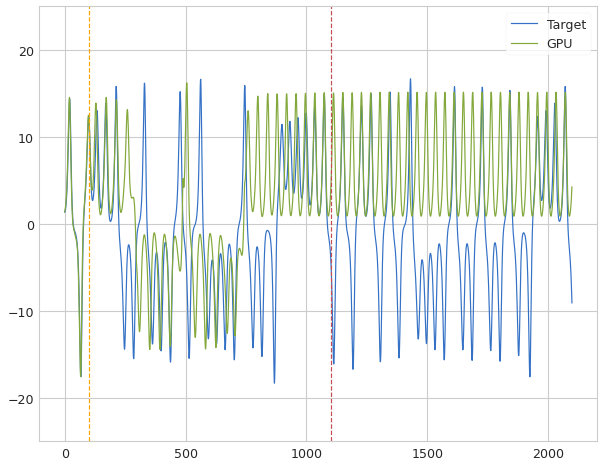

 Iter=47 a=0.269 sr=1.392 amp=1.092  ri=0.779 rr=2.614 loss=0.811439


Iter: 47 #### Diagnostic 0.811439   Time 6.28  Best 0.811 NRMSE 0.220 CD 0.592
Iter: 48 #### Diagnostic 1.305063   Time 4.91  Best 0.811 NRMSE 0.294 CD 1.011
Iter: 49 #### Diagnostic 1.282397   Time 5.83  Best 0.811 NRMSE 0.303 CD 0.980
Iter: 50 #### Diagnostic 1.374820   Time 4.64  Best 0.811 NRMSE 0.313 CD 1.062
Iter: 51 #### Diagnostic 1000.000000   Time 5.40  Best 0.811 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1.406755   Time 5.09  Best 0.811 NRMSE 0.334 CD 1.073
Iter: 53 #### Diagnostic 1.400537   Time 5.37  Best 0.811 NRMSE 0.326 CD 1.074
Iter: 54 #### Diagnostic 1.426044   Time 4.73  Best 0.811 NRMSE 0.308 CD 1.118
Iter: 55 #### Diagnostic 1.379404   Time 7.05  Best 0.811 NRMSE 0.314 CD 1.066
Iter: 56 #### Diagnostic 1.332854   Time 5.48  Best 0.811 NRMSE 0.303 CD 1.030
Iter: 57 #### Diagnostic 1.193448   Time 5.51  Best 0.811 NRMSE 0.282 CD 0.911
Iter: 58 #### Diagnostic 1000.000000   Time 4.10  Best 0

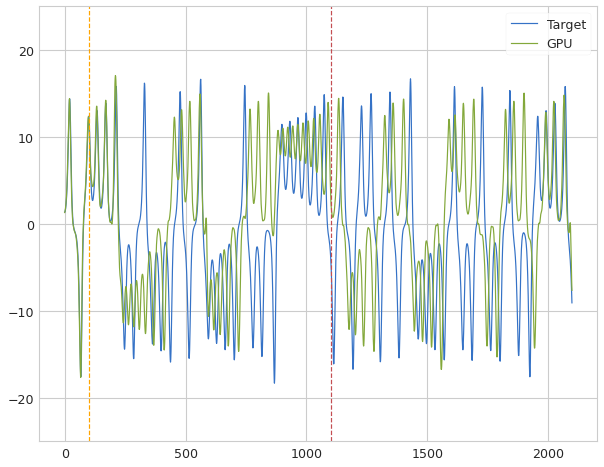

 Iter=32 a=0.295 sr=1.271 amp=0.886  ri=2.855 rr=0.955 loss=0.753655


Iter: 32 #### Diagnostic 0.753655   Time 5.10  Best 0.754 NRMSE 0.219 CD 0.535
Iter: 33 #### Diagnostic 1.110964   Time 4.85  Best 0.754 NRMSE 0.263 CD 0.848
Iter: 34 #### Diagnostic 1.306995   Time 4.30  Best 0.754 NRMSE 0.284 CD 1.023
Iter: 35 #### Diagnostic 1.296085   Time 4.94  Best 0.754 NRMSE 0.284 CD 1.012
Iter: 36 #### Diagnostic 1.298373   Time 4.95  Best 0.754 NRMSE 0.251 CD 1.047
Iter: 37 #### Diagnostic 1.213369   Time 4.76  Best 0.754 NRMSE 0.291 CD 0.923
Iter: 38 #### Diagnostic 1.218267   Time 6.11  Best 0.754 NRMSE 0.282 CD 0.937
Iter: 39 #### Diagnostic 1.358577   Time 5.96  Best 0.754 NRMSE 0.304 CD 1.055
Iter: 40 #### Diagnostic 1000.000000   Time 5.30  Best 0.754 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1.396809   Time 4.89  Best 0.754 NRMSE 0.333 CD 1.063
Iter: 42 #### Diagnostic 1.409441   Time 5.03  Best 0.754 NRMSE 0.293 CD 1.117
Iter: 43 #### Diagnostic 1.384628   Time 5.02  Best 0.75

Iter: 31 #### Diagnostic 1000.000000   Time 4.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.353964   Time 5.76  Best 1000.000 NRMSE 0.292 CD 1.062
Iter: 33 #### Diagnostic 1000.000000   Time 4.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1.375632   Time 4.45  Best 1000.000 NRMSE 0.309 CD 1.066
Iter: 35 #### Diagnostic 1.360572   Time 5.59  Best 1000.000 NRMSE 0.315 CD 1.046
Iter: 36 #### Diagnostic 1.202422   Time 4.80  Best 1000.000 NRMSE 0.275 CD 0.927
Iter: 37 #### Diagnostic 1.250382   Time 4.90  Best 1000.000 NRMSE 0.322 CD 0.928
Iter: 38 #### Diagnostic 1.040289   Time 6.01  Best 1000.000 NRMSE 0.255 CD 0.785
Iter: 39 #### Diagnostic 1.196040   Time 4.87  Best 1000.000 NRMSE 0.268 CD 0.928
Iter: 40 #### Diagnostic 1.053688   Time 6.53  Best 1000.000 NRMSE 0.265 CD 0.789
Iter: 41 #### Diagnostic 1.414054   Time 4.51  Best 1000.000 NRMSE 0.345 CD 1.069
Iter: 42 #### Diagnostic 1000.000000   Time 6.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter

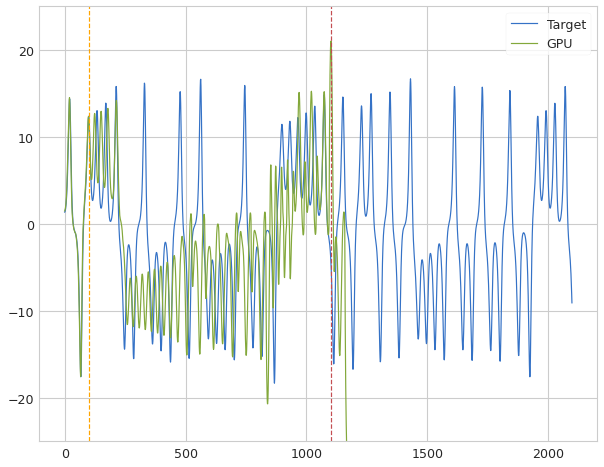

 Iter=69 a=0.266 sr=1.284 amp=1.085  ri=3.313 rr=3.475 loss=0.784867


Iter: 69 #### Diagnostic 0.784867   Time 5.41  Best 0.785 NRMSE 0.221 CD 0.564
Iter: 70 #### Diagnostic 1.383727   Time 5.24  Best 0.785 NRMSE 0.321 CD 1.063
Iter: 71 #### Diagnostic 1.008320   Time 6.03  Best 0.785 NRMSE 0.249 CD 0.760
Iter: 72 #### Diagnostic 1.058809   Time 4.63  Best 0.785 NRMSE 0.255 CD 0.804
Iter: 73 #### Diagnostic 1.427522   Time 4.98  Best 0.785 NRMSE 0.415 CD 1.013
Iter: 74 #### Diagnostic 1.376285   Time 4.75  Best 0.785 NRMSE 0.318 CD 1.058
Iter: 75 #### Diagnostic 1.420385   Time 5.87  Best 0.785 NRMSE 0.356 CD 1.065
Iter: 76 #### Diagnostic 1.297510   Time 5.93  Best 0.785 NRMSE 0.278 CD 1.019
Iter: 77 #### Diagnostic 1.337761   Time 6.40  Best 0.785 NRMSE 0.304 CD 1.033
Iter: 78 #### Diagnostic 1.401430   Time 5.69  Best 0.785 NRMSE 0.337 CD 1.064
Iter: 79 #### Diagnostic 1.391063   Time 4.41  Best 0.785 NRMSE 0.305 CD 1.086
Iter: 80 #### Diagnostic 1.327492   Time 5.30  Best 0.785 NR

Iter: 67 #### Diagnostic 1.266237   Time 6.02  Best 1000.000 NRMSE 0.226 CD 1.040
Iter: 68 #### Diagnostic 1.009868   Time 5.77  Best 1000.000 NRMSE 0.257 CD 0.753
Iter: 69 #### Diagnostic 1.398833   Time 4.54  Best 1000.000 NRMSE 0.332 CD 1.067
Iter: 70 #### Diagnostic 1000.000000   Time 5.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.049533   Time 4.86  Best 1000.000 NRMSE 0.264 CD 0.786
Iter: 72 #### Diagnostic 1.345158   Time 5.46  Best 1000.000 NRMSE 0.285 CD 1.060
Iter: 73 #### Diagnostic 1.407750   Time 5.87  Best 1000.000 NRMSE 0.341 CD 1.067
Iter: 74 #### Diagnostic 1.341852   Time 5.35  Best 1000.000 NRMSE 0.304 CD 1.038
Iter: 75 #### Diagnostic 1.366358   Time 4.91  Best 1000.000 NRMSE 0.296 CD 1.071
Iter: 76 #### Diagnostic 1.399466   Time 5.35  Best 1000.000 NRMSE 0.340 CD 1.060
Iter: 77 #### Diagnostic 1.377068   Time 4.69  Best 1000.000 NRMSE 0.326 CD 1.051
Iter: 78 #### Diagnostic 1.426307   Time 5.46  Best 1000.000 NRMSE 0.362 CD 1.065
Iter: 79 ###

Iter: 57 #### Diagnostic 1.210169   Time 4.49  Best 1000.000 NRMSE 0.281 CD 0.929
Iter: 58 #### Diagnostic 1.364996   Time 5.43  Best 1000.000 NRMSE 0.303 CD 1.062
Iter: 59 #### Diagnostic 1.330486   Time 5.00  Best 1000.000 NRMSE 0.304 CD 1.026
Iter: 60 #### Diagnostic 1.242797   Time 5.20  Best 1000.000 NRMSE 0.305 CD 0.938
Iter: 61 #### Diagnostic 1.399186   Time 6.17  Best 1000.000 NRMSE 0.337 CD 1.062
Iter: 62 #### Diagnostic 1.175766   Time 6.10  Best 1000.000 NRMSE 0.273 CD 0.903
Iter: 63 #### Diagnostic 1000.000000   Time 6.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.383596   Time 5.09  Best 1000.000 NRMSE 0.322 CD 1.062
Iter: 65 #### Diagnostic 1.183929   Time 4.88  Best 1000.000 NRMSE 0.268 CD 0.916
Iter: 66 #### Diagnostic 1.402054   Time 4.44  Best 1000.000 NRMSE 0.338 CD 1.065
Iter: 67 #### Diagnostic 1.472834   Time 5.75  Best 1000.000 NRMSE 0.321 CD 1.152
Iter: 68 #### Diagnostic 1.346778   Time 5.57  Best 1000.000 NRMSE 0.305 CD 1.042
Iter: 69 ###

Iter: 54 #### Diagnostic 1.369534   Time 8.10  Best 1000.000 NRMSE 0.320 CD 1.050
Iter: 55 #### Diagnostic 1.309624   Time 8.62  Best 1000.000 NRMSE 0.286 CD 1.023
Iter: 56 #### Diagnostic 1.418443   Time 6.83  Best 1000.000 NRMSE 0.357 CD 1.061
Iter: 57 #### Diagnostic 1.410424   Time 8.07  Best 1000.000 NRMSE 0.343 CD 1.067
Iter: 58 #### Diagnostic 1.043164   Time 6.49  Best 1000.000 NRMSE 0.243 CD 0.800
Iter: 59 #### Diagnostic 1.368187   Time 5.33  Best 1000.000 NRMSE 0.298 CD 1.070
Iter: 60 #### Diagnostic 1.382882   Time 7.39  Best 1000.000 NRMSE 0.322 CD 1.061
Iter: 61 #### Diagnostic 1000.000000   Time 6.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1.116557   Time 7.78  Best 1000.000 NRMSE 0.268 CD 0.849
Iter: 63 #### Diagnostic 1000.000000   Time 7.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.343156   Time 6.38  Best 1000.000 NRMSE 0.283 CD 1.060
Iter: 65 #### Diagnostic 1.294619   Time 7.56  Best 1000.000 NRMSE 0.294 CD 1.001
Iter: 66

Iter: 51 #### Diagnostic 1000.000000   Time 6.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1.191016   Time 7.42  Best 1000.000 NRMSE 0.283 CD 0.908
Iter: 53 #### Diagnostic 1000.000000   Time 8.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.401578   Time 7.53  Best 1000.000 NRMSE 0.334 CD 1.067
Iter: 55 #### Diagnostic 1.098801   Time 8.53  Best 1000.000 NRMSE 0.277 CD 0.822
Iter: 56 #### Diagnostic 1.378311   Time 6.15  Best 1000.000 NRMSE 0.308 CD 1.071
Iter: 57 #### Diagnostic 1.366035   Time 6.33  Best 1000.000 NRMSE 0.304 CD 1.062
Iter: 58 #### Diagnostic 1.393227   Time 8.67  Best 1000.000 NRMSE 0.330 CD 1.063
Iter: 59 #### Diagnostic 1.242648   Time 6.70  Best 1000.000 NRMSE 0.291 CD 0.952
Iter: 60 #### Diagnostic 1.269913   Time 7.39  Best 1000.000 NRMSE 0.291 CD 0.979
Iter: 61 #### Diagnostic 1000.000000   Time 9.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1.314722   Time 8.45  Best 1000.000 NRMSE 0.300 CD 1.014
Iter

Iter: 48 #### Diagnostic 1.274543   Time 6.32  Best 1000.000 NRMSE 0.291 CD 0.984
Iter: 49 #### Diagnostic 1.243986   Time 8.52  Best 1000.000 NRMSE 0.286 CD 0.958
Iter: 50 #### Diagnostic 1.229516   Time 6.19  Best 1000.000 NRMSE 0.277 CD 0.952
Iter: 51 #### Diagnostic 1.345906   Time 7.88  Best 1000.000 NRMSE 0.285 CD 1.060
Iter: 52 #### Diagnostic 1.387635   Time 8.82  Best 1000.000 NRMSE 0.325 CD 1.063
Iter: 53 #### Diagnostic 1.397159   Time 7.88  Best 1000.000 NRMSE 0.330 CD 1.067
Iter: 54 #### Diagnostic 0.993169   Time 8.59  Best 1000.000 NRMSE 0.251 CD 0.743
Iter: 55 #### Diagnostic 1.367602   Time 5.76  Best 1000.000 NRMSE 0.305 CD 1.063
Iter: 56 #### Diagnostic 1.075332   Time 7.59  Best 1000.000 NRMSE 0.264 CD 0.812
Iter: 57 #### Diagnostic 1000.000000   Time 6.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.364189   Time 8.32  Best 1000.000 NRMSE 0.303 CD 1.062
Iter: 59 #### Diagnostic 1.370508   Time 8.69  Best 1000.000 NRMSE 0.309 CD 1.062
Iter: 60 ###

Iter: 46 #### Diagnostic 1.258693   Time 8.36  Best 1000.000 NRMSE 0.224 CD 1.035
Iter: 47 #### Diagnostic 1.405976   Time 8.76  Best 1000.000 NRMSE 0.343 CD 1.063
Iter: 48 #### Diagnostic 1.401085   Time 6.38  Best 1000.000 NRMSE 0.319 CD 1.082
Iter: 49 #### Diagnostic 1.348708   Time 8.52  Best 1000.000 NRMSE 0.296 CD 1.052
Iter: 50 #### Diagnostic 1.387703   Time 7.99  Best 1000.000 NRMSE 0.325 CD 1.063
Iter: 51 #### Diagnostic 1000.000000   Time 7.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1.121569   Time 8.32  Best 1000.000 NRMSE 0.266 CD 0.855
Iter: 53 #### Diagnostic 1.342992   Time 7.23  Best 1000.000 NRMSE 0.315 CD 1.028
Iter: 54 #### Diagnostic 1.162572   Time 6.37  Best 1000.000 NRMSE 0.289 CD 0.873
Iter: 55 #### Diagnostic 1.109162   Time 8.71  Best 1000.000 NRMSE 0.262 CD 0.847
Iter: 56 #### Diagnostic 1000.000000   Time 8.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1.318207   Time 7.67  Best 1000.000 NRMSE 0.327 CD 0.991
Iter: 58

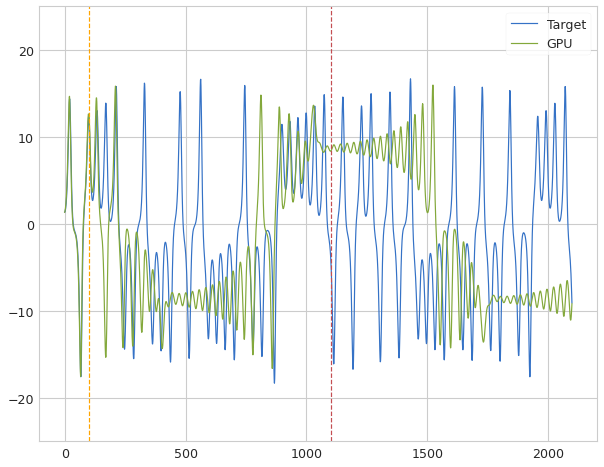

 Iter=75 a=0.338 sr=1.437 amp=1.086  ri=0.200 rr=2.432 loss=0.736450


Iter: 75 #### Diagnostic 0.736450   Time 7.72  Best 0.736 NRMSE 0.219 CD 0.517
Iter: 76 #### Diagnostic 1.362495   Time 7.82  Best 0.736 NRMSE 0.305 CD 1.058
Iter: 77 #### Diagnostic 1.354945   Time 9.29  Best 0.736 NRMSE 0.303 CD 1.052
Iter: 78 #### Diagnostic 1.271800   Time 8.41  Best 0.736 NRMSE 0.278 CD 0.994
Iter: 79 #### Diagnostic 1.034726   Time 8.49  Best 0.736 NRMSE 0.265 CD 0.770
Iter: 80 #### Diagnostic 1.389043   Time 7.61  Best 0.736 NRMSE 0.322 CD 1.067
Iter: 81 #### Diagnostic 1.362560   Time 6.70  Best 0.736 NRMSE 0.322 CD 1.041
Iter: 82 #### Diagnostic 1.262290   Time 6.85  Best 0.736 NRMSE 0.282 CD 0.981
Iter: 83 #### Diagnostic 0.957395   Time 7.27  Best 0.736 NRMSE 0.249 CD 0.709
Iter: 84 #### Diagnostic 1.086934   Time 8.70  Best 0.736 NRMSE 0.273 CD 0.814
Iter: 85 #### Diagnostic 1.392386   Time 6.74  Best 0.736 NRMSE 0.306 CD 1.087
Iter: 86 #### Diagnostic 1.383990   Time 7.07  Best 0.736 NR

Iter: 65 #### Diagnostic 1.124117   Time 6.83  Best 1000.000 NRMSE 0.255 CD 0.869
Iter: 66 #### Diagnostic 1.234601   Time 8.02  Best 1000.000 NRMSE 0.283 CD 0.952
Iter: 67 #### Diagnostic 1.317827   Time 9.66  Best 1000.000 NRMSE 0.292 CD 1.026
Iter: 68 #### Diagnostic 1.380992   Time 6.22  Best 1000.000 NRMSE 0.317 CD 1.064
Iter: 69 #### Diagnostic 1000.000000   Time 8.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1.300991   Time 8.97  Best 1000.000 NRMSE 0.292 CD 1.009
Iter: 71 #### Diagnostic 1.206457   Time 7.37  Best 1000.000 NRMSE 0.299 CD 0.908
Iter: 72 #### Diagnostic 1.353874   Time 6.58  Best 1000.000 NRMSE 0.304 CD 1.050
Iter: 73 #### Diagnostic 1.302376   Time 9.17  Best 1000.000 NRMSE 0.291 CD 1.011
Iter: 74 #### Diagnostic 1.088313   Time 7.20  Best 1000.000 NRMSE 0.247 CD 0.841
Iter: 75 #### Diagnostic 1000.000000   Time 7.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.390947   Time 7.23  Best 1000.000 NRMSE 0.334 CD 1.057
Iter: 77

Iter: 62 #### Diagnostic 1000.000000   Time 7.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.091743   Time 8.51  Best 1000.000 NRMSE 0.272 CD 0.819
Iter: 64 #### Diagnostic 1.428050   Time 8.29  Best 1000.000 NRMSE 0.309 CD 1.119
Iter: 65 #### Diagnostic 1.403018   Time 8.48  Best 1000.000 NRMSE 0.339 CD 1.064
Iter: 66 #### Diagnostic 1.374733   Time 8.28  Best 1000.000 NRMSE 0.318 CD 1.057
Iter: 67 #### Diagnostic 1.326396   Time 7.22  Best 1000.000 NRMSE 0.291 CD 1.036
Iter: 68 #### Diagnostic 1.401639   Time 8.42  Best 1000.000 NRMSE 0.334 CD 1.067
Iter: 69 #### Diagnostic 1.395076   Time 9.33  Best 1000.000 NRMSE 0.332 CD 1.063
Iter: 70 #### Diagnostic 1.312812   Time 8.01  Best 1000.000 NRMSE 0.293 CD 1.020
Iter: 71 #### Diagnostic 1.400609   Time 9.00  Best 1000.000 NRMSE 0.332 CD 1.069
Iter: 72 #### Diagnostic 1.389492   Time 7.71  Best 1000.000 NRMSE 0.326 CD 1.063
Iter: 73 #### Diagnostic 1.405007   Time 7.42  Best 1000.000 NRMSE 0.312 CD 1.093
Iter: 74 ###

Iter: 60 #### Diagnostic 1.206144   Time 9.06  Best 1000.000 NRMSE 0.282 CD 0.924
Iter: 61 #### Diagnostic 1.611430   Time 7.46  Best 1000.000 NRMSE 0.338 CD 1.273
Iter: 62 #### Diagnostic 1.349919   Time 6.69  Best 1000.000 NRMSE 0.297 CD 1.053
Iter: 63 #### Diagnostic 1.397891   Time 5.21  Best 1000.000 NRMSE 0.331 CD 1.067
Iter: 64 #### Diagnostic 1.048474   Time 7.36  Best 1000.000 NRMSE 0.257 CD 0.792
Iter: 65 #### Diagnostic 1.377413   Time 9.06  Best 1000.000 NRMSE 0.313 CD 1.064
Iter: 66 #### Diagnostic 1.515018   Time 8.19  Best 1000.000 NRMSE 0.321 CD 1.194
Iter: 67 #### Diagnostic 1.270515   Time 8.58  Best 1000.000 NRMSE 0.285 CD 0.986
Iter: 68 #### Diagnostic 1.516364   Time 7.34  Best 1000.000 NRMSE 0.333 CD 1.184
Iter: 69 #### Diagnostic 1.410542   Time 8.53  Best 1000.000 NRMSE 0.299 CD 1.112
Iter: 70 #### Diagnostic 1.110269   Time 7.45  Best 1000.000 NRMSE 0.266 CD 0.844
Iter: 71 #### Diagnostic 1000.000000   Time 8.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 ###

Iter: 57 #### Diagnostic 1000.000000   Time 8.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 6.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 5.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1.398727   Time 8.11  Best 1000.000 NRMSE 0.333 CD 1.065
Iter: 61 #### Diagnostic 1.382490   Time 5.74  Best 1000.000 NRMSE 0.320 CD 1.063
Iter: 62 #### Diagnostic 1.438743   Time 7.59  Best 1000.000 NRMSE 0.322 CD 1.117
Iter: 63 #### Diagnostic 1.386011   Time 7.31  Best 1000.000 NRMSE 0.324 CD 1.062
Iter: 64 #### Diagnostic 1.377190   Time 7.85  Best 1000.000 NRMSE 0.314 CD 1.063
Iter: 65 #### Diagnostic 1.259387   Time 7.59  Best 1000.000 NRMSE 0.290 CD 0.970
Iter: 66 #### Diagnostic 1.392103   Time 9.10  Best 1000.000 NRMSE 0.327 CD 1.065
Iter: 67 #### Diagnostic 1.269480   Time 7.26  Best 1000.000 NRMSE 0.291 CD 0.979
Iter: 68 #### Diagnostic 1.338057   Time 8.45  Best 1000.000 NRMSE 0.279 CD 1.059
Iter

Iter: 55 #### Diagnostic 1.412490   Time 6.12  Best 1000.000 NRMSE 0.349 CD 1.063
Iter: 56 #### Diagnostic 1.337086   Time 8.07  Best 1000.000 NRMSE 0.305 CD 1.032
Iter: 57 #### Diagnostic 1.040778   Time 7.52  Best 1000.000 NRMSE 0.261 CD 0.780
Iter: 58 #### Diagnostic 1.398076   Time 6.93  Best 1000.000 NRMSE 0.337 CD 1.061
Iter: 59 #### Diagnostic 1.393090   Time 9.03  Best 1000.000 NRMSE 0.332 CD 1.062
Iter: 60 #### Diagnostic 1.331889   Time 7.26  Best 1000.000 NRMSE 0.292 CD 1.040
Iter: 61 #### Diagnostic 1.402170   Time 7.53  Best 1000.000 NRMSE 0.340 CD 1.063
Iter: 62 #### Diagnostic 1.142387   Time 8.55  Best 1000.000 NRMSE 0.271 CD 0.872
Iter: 63 #### Diagnostic 1.047948   Time 6.50  Best 1000.000 NRMSE 0.253 CD 0.795
Iter: 64 #### Diagnostic 1.309500   Time 8.05  Best 1000.000 NRMSE 0.298 CD 1.012
Iter: 65 #### Diagnostic 1.400411   Time 8.34  Best 1000.000 NRMSE 0.337 CD 1.063
Iter: 66 #### Diagnostic 1.074116   Time 8.88  Best 1000.000 NRMSE 0.259 CD 0.815
Iter: 67 #### Di

Iter: 49 #### Diagnostic 1.370417   Time 6.84  Best 1000.000 NRMSE 0.311 CD 1.059
Iter: 50 #### Diagnostic 0.911801   Time 7.62  Best 1000.000 NRMSE 0.242 CD 0.669
Iter: 51 #### Diagnostic 1000.000000   Time 8.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1.342998   Time 6.71  Best 1000.000 NRMSE 0.283 CD 1.060
Iter: 53 #### Diagnostic 1.398901   Time 7.85  Best 1000.000 NRMSE 0.330 CD 1.069
Iter: 54 #### Diagnostic 1000.000000   Time 6.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1.134388   Time 6.91  Best 1000.000 NRMSE 0.261 CD 0.873
Iter: 56 #### Diagnostic 1.385393   Time 7.32  Best 1000.000 NRMSE 0.321 CD 1.064
Iter: 57 #### Diagnostic 1.298096   Time 5.96  Best 1000.000 NRMSE 0.293 CD 1.005
Iter: 58 #### Diagnostic 1.274325   Time 8.72  Best 1000.000 NRMSE 0.287 CD 0.987
Iter: 59 #### Diagnostic 1.314658   Time 7.92  Best 1000.000 NRMSE 0.289 CD 1.026
Iter: 60 #### Diagnostic 1.378881   Time 6.88  Best 1000.000 NRMSE 0.317 CD 1.062
Iter: 61

Iter: 46 #### Diagnostic 1.320369   Time 6.82  Best 1000.000 NRMSE 0.311 CD 1.009
Iter: 47 #### Diagnostic 1000.000000   Time 6.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.324639   Time 7.74  Best 1000.000 NRMSE 0.304 CD 1.020
Iter: 49 #### Diagnostic 1.137592   Time 8.29  Best 1000.000 NRMSE 0.275 CD 0.863
Iter: 50 #### Diagnostic 1.381499   Time 8.07  Best 1000.000 NRMSE 0.318 CD 1.064
Iter: 51 #### Diagnostic 1.393662   Time 5.72  Best 1000.000 NRMSE 0.335 CD 1.059
Iter: 52 #### Diagnostic 1.328343   Time 8.58  Best 1000.000 NRMSE 0.291 CD 1.037
Iter: 53 #### Diagnostic 1.388276   Time 9.07  Best 1000.000 NRMSE 0.324 CD 1.064
Iter: 54 #### Diagnostic 1.140826   Time 7.62  Best 1000.000 NRMSE 0.271 CD 0.869
Iter: 55 #### Diagnostic 1000.000000   Time 8.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.383288   Time 7.86  Best 1000.000 NRMSE 0.335 CD 1.048
Iter: 57 #### Diagnostic 1.288313   Time 8.13  Best 1000.000 NRMSE 0.292 CD 0.996
Iter: 58

Iter: 43 #### Diagnostic 1.360990   Time 8.53  Best 1000.000 NRMSE 0.313 CD 1.048
Iter: 44 #### Diagnostic 1.377927   Time 7.35  Best 1000.000 NRMSE 0.315 CD 1.063
Iter: 45 #### Diagnostic 1.419153   Time 8.08  Best 1000.000 NRMSE 0.343 CD 1.076
Iter: 46 #### Diagnostic 1.330917   Time 7.70  Best 1000.000 NRMSE 0.275 CD 1.056
Iter: 47 #### Diagnostic 0.971035   Time 10.00  Best 1000.000 NRMSE 0.255 CD 0.716
Iter: 48 #### Diagnostic 1.397917   Time 7.63  Best 1000.000 NRMSE 0.326 CD 1.072
Iter: 49 #### Diagnostic 1.375527   Time 6.21  Best 1000.000 NRMSE 0.310 CD 1.065
Iter: 50 #### Diagnostic 1.059002   Time 7.17  Best 1000.000 NRMSE 0.266 CD 0.793
Iter: 51 #### Diagnostic 1.359717   Time 8.47  Best 1000.000 NRMSE 0.304 CD 1.056
Iter: 52 #### Diagnostic 1.388251   Time 8.21  Best 1000.000 NRMSE 0.323 CD 1.065
Iter: 53 #### Diagnostic 1000.000000   Time 6.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.390025   Time 7.69  Best 1000.000 NRMSE 0.331 CD 1.059
Iter: 55 ##

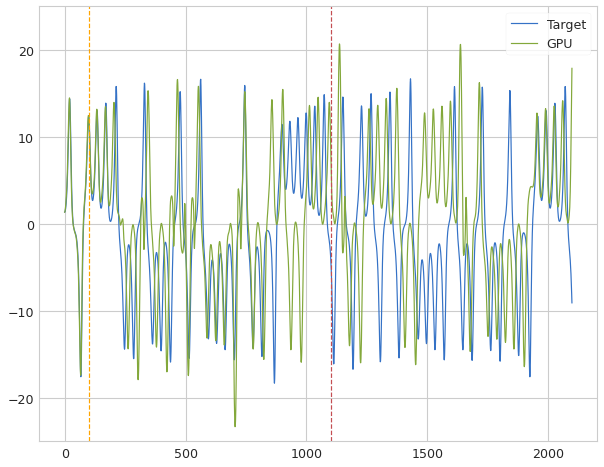

 Iter=66 a=0.251 sr=1.267 amp=0.952  ri=1.972 rr=2.555 loss=0.745045


Iter: 66 #### Diagnostic 0.745045   Time 7.65  Best 0.745 NRMSE 0.215 CD 0.530
Iter: 67 #### Diagnostic 1000.000000   Time 7.36  Best 0.745 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1.035717   Time 8.26  Best 0.745 NRMSE 0.257 CD 0.779
Iter: 69 #### Diagnostic 1.386556   Time 7.70  Best 0.745 NRMSE 0.331 CD 1.055
Iter: 70 #### Diagnostic 1.327626   Time 9.33  Best 0.745 NRMSE 0.294 CD 1.033
Iter: 71 #### Diagnostic 1.383681   Time 7.36  Best 0.745 NRMSE 0.319 CD 1.064
Iter: 72 #### Diagnostic 1.370359   Time 7.36  Best 0.745 NRMSE 0.308 CD 1.062
Iter: 73 #### Diagnostic 1.378504   Time 8.81  Best 0.745 NRMSE 0.326 CD 1.053
Iter: 74 #### Diagnostic 1.390422   Time 5.99  Best 0.745 NRMSE 0.324 CD 1.067
Iter: 75 #### Diagnostic 1000.000000   Time 8.70  Best 0.745 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.261284   Time 9.42  Best 0.745 NRMSE 0.299 CD 0.962
Iter: 77 #### Diagnostic 1000.000000   Time 8.37  Be

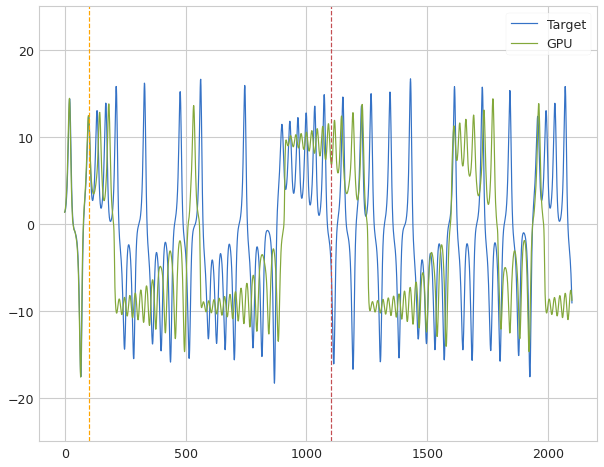

 Iter=42 a=0.371 sr=1.327 amp=0.896  ri=1.491 rr=2.419 loss=0.772798


Iter: 42 #### Diagnostic 0.772798   Time 6.80  Best 0.773 NRMSE 0.227 CD 0.546
Iter: 43 #### Diagnostic 1.372376   Time 8.61  Best 0.773 NRMSE 0.310 CD 1.062
Iter: 44 #### Diagnostic 1.485615   Time 8.69  Best 0.773 NRMSE 0.314 CD 1.171
Iter: 45 #### Diagnostic 1.076595   Time 7.03  Best 0.773 NRMSE 0.266 CD 0.811
Iter: 46 #### Diagnostic 1.016126   Time 9.74  Best 0.773 NRMSE 0.258 CD 0.758
Iter: 47 #### Diagnostic 1.030402   Time 7.81  Best 0.773 NRMSE 0.252 CD 0.778
Iter: 48 #### Diagnostic 1.387443   Time 7.57  Best 0.773 NRMSE 0.324 CD 1.063
Iter: 49 #### Diagnostic 1.374945   Time 7.89  Best 0.773 NRMSE 0.313 CD 1.062
Iter: 50 #### Diagnostic 1.389871   Time 9.76  Best 0.773 NRMSE 0.327 CD 1.063
Iter: 51 #### Diagnostic 1.395461   Time 7.10  Best 0.773 NRMSE 0.324 CD 1.071
Iter: 52 #### Diagnostic 1.400009   Time 7.28  Best 0.773 NRMSE 0.334 CD 1.066
Iter: 53 #### Diagnostic 1.345906   Time 8.74  Best 0.773 NR

Iter: 41 #### Diagnostic 1.360937   Time 7.13  Best 1000.000 NRMSE 0.317 CD 1.044
Iter: 42 #### Diagnostic 1.319228   Time 8.24  Best 1000.000 NRMSE 0.297 CD 1.023
Iter: 43 #### Diagnostic 1.412868   Time 8.64  Best 1000.000 NRMSE 0.349 CD 1.063
Iter: 44 #### Diagnostic 1.177880   Time 8.05  Best 1000.000 NRMSE 0.279 CD 0.899
Iter: 45 #### Diagnostic 1.397954   Time 7.18  Best 1000.000 NRMSE 0.325 CD 1.073
Iter: 46 #### Diagnostic 1.392717   Time 8.11  Best 1000.000 NRMSE 0.318 CD 1.074
Iter: 47 #### Diagnostic 1000.000000   Time 8.99  Best 1000.000 NRMSE 1014255769132.184 CD 0.977
Iter: 48 #### Diagnostic 1.335242   Time 8.47  Best 1000.000 NRMSE 0.304 CD 1.031
Iter: 49 #### Diagnostic 1.338714   Time 8.51  Best 1000.000 NRMSE 0.393 CD 0.945
Iter: 50 #### Diagnostic 1.160074   Time 5.74  Best 1000.000 NRMSE 0.273 CD 0.887
Iter: 51 #### Diagnostic 1.369272   Time 7.27  Best 1000.000 NRMSE 0.307 CD 1.062
Iter: 52 #### Diagnostic 1000.000000   Time 8.91  Best 1000.000 NRMSE 1000.000 CD n

Iter: 31 #### Diagnostic 1000.000000   Time 7.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 7.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1.314531   Time 7.39  Best 1000.000 NRMSE 0.285 CD 1.029
Iter: 34 #### Diagnostic 1.406518   Time 8.01  Best 1000.000 NRMSE 0.340 CD 1.067
Iter: 35 #### Diagnostic 1.453754   Time 6.73  Best 1000.000 NRMSE 0.311 CD 1.143
Iter: 36 #### Diagnostic 1.392353   Time 7.49  Best 1000.000 NRMSE 0.328 CD 1.064
Iter: 37 #### Diagnostic 1.398070   Time 6.92  Best 1000.000 NRMSE 0.328 CD 1.070
Iter: 38 #### Diagnostic 1.179565   Time 7.44  Best 1000.000 NRMSE 0.271 CD 0.908
Iter: 39 #### Diagnostic 1.386837   Time 8.43  Best 1000.000 NRMSE 0.323 CD 1.064
Iter: 40 #### Diagnostic 1.413325   Time 7.86  Best 1000.000 NRMSE 0.337 CD 1.077
Iter: 41 #### Diagnostic 1000.000000   Time 6.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.454974   Time 7.63  Best 1000.000 NRMSE 0.306 CD 1.149
Iter

Iter: 28 #### Diagnostic 1.147987   Time 9.64  Best 1000.000 NRMSE 0.280 CD 0.868
Iter: 29 #### Diagnostic 1.389975   Time 7.14  Best 1000.000 NRMSE 0.323 CD 1.066
Iter: 30 #### Diagnostic 1.397936   Time 6.35  Best 1000.000 NRMSE 0.335 CD 1.063
Iter: 31 #### Diagnostic 1.336008   Time 7.01  Best 1000.000 NRMSE 0.288 CD 1.048
Iter: 32 #### Diagnostic 1.373107   Time 8.58  Best 1000.000 NRMSE 0.310 CD 1.063
Iter: 33 #### Diagnostic 1.023113   Time 8.44  Best 1000.000 NRMSE 0.254 CD 0.769
Iter: 34 #### Diagnostic 1.402640   Time 7.69  Best 1000.000 NRMSE 0.335 CD 1.067
Iter: 35 #### Diagnostic 1000.000000   Time 7.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1.409457   Time 6.91  Best 1000.000 NRMSE 0.345 CD 1.064
Iter: 37 #### Diagnostic 1.399478   Time 5.81  Best 1000.000 NRMSE 0.332 CD 1.067
Iter: 38 #### Diagnostic 1.370931   Time 7.34  Best 1000.000 NRMSE 0.340 CD 1.031
Iter: 39 #### Diagnostic 1.388644   Time 6.58  Best 1000.000 NRMSE 0.325 CD 1.064
Iter: 40 ###

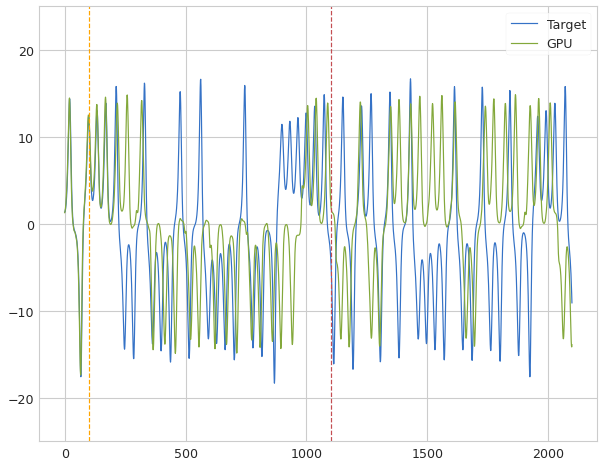

 Iter=58 a=0.345 sr=1.405 amp=0.837  ri=1.771 rr=2.981 loss=0.814483


Iter: 58 #### Diagnostic 0.814483   Time 7.80  Best 0.814 NRMSE 0.215 CD 0.599
Iter: 59 #### Diagnostic 1.077635   Time 7.95  Best 0.814 NRMSE 0.271 CD 0.807
Iter: 60 #### Diagnostic 1.395905   Time 7.73  Best 0.814 NRMSE 0.321 CD 1.074
Iter: 61 #### Diagnostic 1.115616   Time 6.10  Best 0.814 NRMSE 0.279 CD 0.837
Iter: 62 #### Diagnostic 1.371770   Time 8.21  Best 0.814 NRMSE 0.318 CD 1.054
Iter: 63 #### Diagnostic 1.381774   Time 7.99  Best 0.814 NRMSE 0.317 CD 1.065
Iter: 64 #### Diagnostic 1000.000000   Time 8.61  Best 0.814 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.353551   Time 6.97  Best 0.814 NRMSE 0.294 CD 1.059
Iter: 66 #### Diagnostic 1.107111   Time 6.80  Best 0.814 NRMSE 0.278 CD 0.829
Iter: 67 #### Diagnostic 1.393902   Time 7.06  Best 0.814 NRMSE 0.322 CD 1.072
Iter: 68 #### Diagnostic 1.339132   Time 8.50  Best 0.814 NRMSE 0.290 CD 1.050
Iter: 69 #### Diagnostic 1.152372   Time 6.84  Best 0.81

Iter: 56 #### Diagnostic 1.392016   Time 7.51  Best 1000.000 NRMSE 0.327 CD 1.065
Iter: 57 #### Diagnostic 1.186894   Time 7.57  Best 1000.000 NRMSE 0.291 CD 0.896
Iter: 58 #### Diagnostic 1.360493   Time 6.40  Best 1000.000 NRMSE 0.297 CD 1.063
Iter: 59 #### Diagnostic 1.163539   Time 8.43  Best 1000.000 NRMSE 0.285 CD 0.879
Iter: 60 #### Diagnostic 1.393654   Time 10.33  Best 1000.000 NRMSE 0.330 CD 1.063
Iter: 61 #### Diagnostic 1.324891   Time 7.01  Best 1000.000 NRMSE 0.293 CD 1.031
Iter: 62 #### Diagnostic 1.384485   Time 8.38  Best 1000.000 NRMSE 0.322 CD 1.062
Iter: 63 #### Diagnostic 1000.000000   Time 9.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.392322   Time 7.35  Best 1000.000 NRMSE 0.328 CD 1.064
Iter: 65 #### Diagnostic 1.439847   Time 8.09  Best 1000.000 NRMSE 0.312 CD 1.127
Iter: 66 #### Diagnostic 1.394252   Time 7.58  Best 1000.000 NRMSE 0.333 CD 1.061
Iter: 67 #### Diagnostic 1.287614   Time 6.56  Best 1000.000 NRMSE 0.292 CD 0.996
Iter: 68 ##

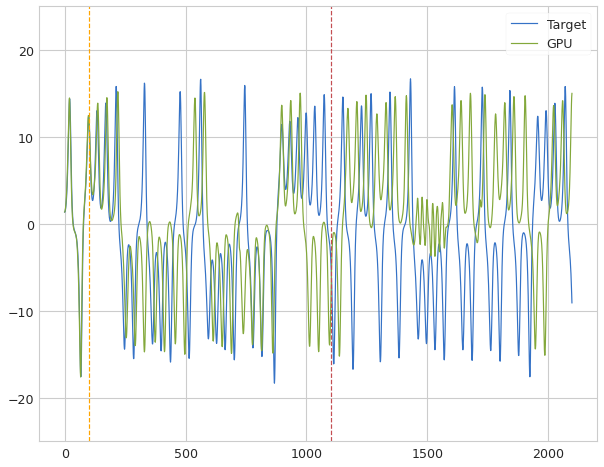

 Iter=1 a=0.368 sr=1.345 amp=0.986  ri=1.099 rr=2.240 loss=0.834437


Iter: 1 #### Diagnostic 0.834437   Time 6.67  Best 0.834 NRMSE 0.224 CD 0.610
Iter: 2 #### Diagnostic 1.396380   Time 7.43  Best 0.834 NRMSE 0.318 CD 1.078
Iter: 3 #### Diagnostic 1.353633   Time 8.33  Best 0.834 NRMSE 0.291 CD 1.063
Iter: 4 #### Diagnostic 1.268440   Time 7.26  Best 0.834 NRMSE 0.286 CD 0.983
Iter: 5 #### Diagnostic 1.387669   Time 8.36  Best 0.834 NRMSE 0.326 CD 1.061
Iter: 6 #### Diagnostic 1.389834   Time 6.97  Best 0.834 NRMSE 0.324 CD 1.066
Iter: 7 #### Diagnostic 1000.000000   Time 8.15  Best 0.834 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 6.49  Best 0.834 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.400866   Time 8.51  Best 0.834 NRMSE 0.302 CD 1.099
Iter: 10 #### Diagnostic 1.392461   Time 5.69  Best 0.834 NRMSE 0.328 CD 1.064
Iter: 11 #### Diagnostic 1000.000000   Time 8.18  Best 0.834 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1.394437   Time 5.81  Best 0.834 

Iter: 1 #### Diagnostic 1000.000000   Time 8.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.394769   Time 8.47  Best 1000.000 NRMSE 0.329 CD 1.066


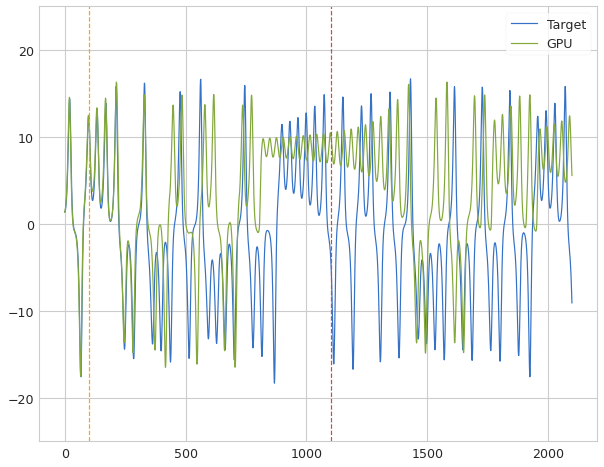

 Iter=3 a=0.329 sr=1.354 amp=0.997  ri=2.421 rr=0.157 loss=0.787641


Iter: 3 #### Diagnostic 0.787641   Time 7.13  Best 0.788 NRMSE 0.222 CD 0.566
Iter: 4 #### Diagnostic 1.391953   Time 9.49  Best 0.788 NRMSE 0.325 CD 1.067
Iter: 5 #### Diagnostic 1.387880   Time 7.76  Best 0.788 NRMSE 0.321 CD 1.066
Iter: 6 #### Diagnostic 1.475163   Time 7.41  Best 0.788 NRMSE 0.317 CD 1.158
Iter: 7 #### Diagnostic 1.388053   Time 8.51  Best 0.788 NRMSE 0.323 CD 1.065
Iter: 8 #### Diagnostic 1000.000000   Time 8.20  Best 0.788 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.151435   Time 7.39  Best 0.788 NRMSE 0.279 CD 0.873
Iter: 10 #### Diagnostic 1.317684   Time 6.46  Best 0.788 NRMSE 0.305 CD 1.013
Iter: 11 #### Diagnostic 1.395348   Time 8.96  Best 0.788 NRMSE 0.331 CD 1.064
Iter: 12 #### Diagnostic 1.353442   Time 7.46  Best 0.788 NRMSE 0.293 CD 1.061
Iter: 13 #### Diagnostic 1.368623   Time 8.39  Best 0.788 NRMSE 0.313 CD 1.056
Iter: 14 #### Diagnostic 1.388610   Time 7.63  Best 0.788 NRMSE 

Iter: 0 #### Diagnostic 1.381022   Time 7.60  Best 1000.000 NRMSE 0.316 CD 1.065
Iter: 1 #### Diagnostic 1.408526   Time 7.58  Best 1000.000 NRMSE 0.337 CD 1.071
Iter: 2 #### Diagnostic 1.375961   Time 8.59  Best 1000.000 NRMSE 0.313 CD 1.063
Iter: 3 #### Diagnostic 1.413904   Time 8.14  Best 1000.000 NRMSE 0.311 CD 1.103
Iter: 4 #### Diagnostic 1.150043   Time 7.70  Best 1000.000 NRMSE 0.273 CD 0.877
Iter: 5 #### Diagnostic 1.379391   Time 5.18  Best 1000.000 NRMSE 0.320 CD 1.059
Iter: 6 #### Diagnostic 1.386081   Time 6.47  Best 1000.000 NRMSE 0.319 CD 1.067
Iter: 7 #### Diagnostic 1.385504   Time 7.54  Best 1000.000 NRMSE 0.323 CD 1.062
Iter: 8 #### Diagnostic 1000.000000   Time 8.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.335195   Time 7.24  Best 1000.000 NRMSE 0.277 CD 1.058
Iter: 10 #### Diagnostic 1.346418   Time 5.89  Best 1000.000 NRMSE 0.285 CD 1.061
Iter: 11 #### Diagnostic 1.385193   Time 7.29  Best 1000.000 NRMSE 0.319 CD 1.066
Iter: 12 #### Diagnost


Best result = 0.9333060257269171
a = 0.30839413064289917
sr = 1.3356637772022955
amp = 0.964695497792952
ri = 1.5833775262691299
rr = 1.6379339864771534
********** Size 20 -- Run 1 ***********
Iter: 0 #### Diagnostic 1.502704   Time 8.18  Best 1000.000 NRMSE 0.324 CD 1.179
Iter: 1 #### Diagnostic 1.403269   Time 6.82  Best 1000.000 NRMSE 0.338 CD 1.065
Iter: 2 #### Diagnostic 1.368744   Time 8.04  Best 1000.000 NRMSE 0.297 CD 1.072
Iter: 3 #### Diagnostic 1.393263   Time 7.99  Best 1000.000 NRMSE 0.329 CD 1.064
Iter: 4 #### Diagnostic 1.396621   Time 6.24  Best 1000.000 NRMSE 0.317 CD 1.080
Iter: 5 #### Diagnostic 1.383331   Time 8.31  Best 1000.000 NRMSE 0.320 CD 1.063
Iter: 6 #### Diagnostic 1.378773   Time 7.38  Best 1000.000 NRMSE 0.316 CD 1.063
Iter: 7 #### Diagnostic 1.326797   Time 6.57  Best 1000.000 NRMSE 0.296 CD 1.031
Iter: 8 #### Diagnostic 1.326326   Time 7.79  Best 1000.000 NRMSE 0.272 CD 1.054
Iter: 9 #### Diagnostic 1.329030   Time 6.72  Best 1000.000 NRMSE 0.272 CD 1.

Iter: 98 #### Diagnostic 1.118048   Time 9.05  Best 1000.000 NRMSE 0.294 CD 0.824
Iter: 99 #### Diagnostic 1.131104   Time 5.92  Best 1000.000 NRMSE 0.275 CD 0.856

Best result = 0.9918108706368982
a = 0.3463306074052369
sr = 1.352963339097295
amp = 0.8698887848249847
ri = 2.019215755913297
rr = 2.60191586174058
********** Size 20 -- Run 2 ***********
Iter: 0 #### Diagnostic 1.320776   Time 6.92  Best 1000.000 NRMSE 0.284 CD 1.036
Iter: 1 #### Diagnostic 1.386381   Time 7.21  Best 1000.000 NRMSE 0.318 CD 1.069
Iter: 2 #### Diagnostic 1.298636   Time 7.30  Best 1000.000 NRMSE 0.292 CD 1.007
Iter: 3 #### Diagnostic 1.326124   Time 7.77  Best 1000.000 NRMSE 0.286 CD 1.040
Iter: 4 #### Diagnostic 0.976840   Time 8.05  Best 1000.000 NRMSE 0.245 CD 0.732
Iter: 5 #### Diagnostic 1.387848   Time 7.34  Best 1000.000 NRMSE 0.323 CD 1.065
Iter: 6 #### Diagnostic 1.357502   Time 7.72  Best 1000.000 NRMSE 0.295 CD 1.063
Iter: 7 #### Diagnostic 1.018103   Time 7.73  Best 1000.000 NRMSE 0.263 CD 0.75

Iter: 96 #### Diagnostic 1.395192   Time 6.83  Best 1000.000 NRMSE 0.328 CD 1.067
Iter: 97 #### Diagnostic 1.397378   Time 8.52  Best 1000.000 NRMSE 0.337 CD 1.061
Iter: 98 #### Diagnostic 1.369910   Time 6.16  Best 1000.000 NRMSE 0.305 CD 1.065
Iter: 99 #### Diagnostic 1.370790   Time 7.41  Best 1000.000 NRMSE 0.308 CD 1.063

Best result = 0.8996053729940463
a = 0.27339991523268503
sr = 1.2743194617043314
amp = 1.013616329619784
ri = 1.5008734106806803
rr = 2.2557231844658867
********** Size 20 -- Run 3 ***********
Iter: 0 #### Diagnostic 1.344934   Time 5.83  Best 1000.000 NRMSE 0.285 CD 1.060
Iter: 1 #### Diagnostic 1.391378   Time 6.28  Best 1000.000 NRMSE 0.312 CD 1.080
Iter: 2 #### Diagnostic 1.362171   Time 5.93  Best 1000.000 NRMSE 0.301 CD 1.061
Iter: 3 #### Diagnostic 1.008501   Time 7.59  Best 1000.000 NRMSE 0.204 CD 0.804
Iter: 4 #### Diagnostic 1.461773   Time 6.94  Best 1000.000 NRMSE 0.325 CD 1.137
Iter: 5 #### Diagnostic 1.372210   Time 8.28  Best 1000.000 NRMSE 0.310 C

Iter: 94 #### Diagnostic 1.385105   Time 8.07  Best 1000.000 NRMSE 0.331 CD 1.055
Iter: 95 #### Diagnostic 1.215334   Time 8.06  Best 1000.000 NRMSE 0.280 CD 0.935
Iter: 96 #### Diagnostic 1.354948   Time 7.44  Best 1000.000 NRMSE 0.294 CD 1.061
Iter: 97 #### Diagnostic 1.316038   Time 8.51  Best 1000.000 NRMSE 0.263 CD 1.053
Iter: 98 #### Diagnostic 1.376991   Time 6.33  Best 1000.000 NRMSE 0.315 CD 1.062
Iter: 99 #### Diagnostic 1000.000000   Time 5.76  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.9898470487727806
a = 0.3351945023520658
sr = 1.3973430933165303
amp = 1.0534499322845832
ri = 3.1586152258139406
rr = 3.328752948783828
********** Size 20 -- Run 4 ***********
Iter: 0 #### Diagnostic 1.365606   Time 6.40  Best 1000.000 NRMSE 0.323 CD 1.043
Iter: 1 #### Diagnostic 1.391518   Time 7.59  Best 1000.000 NRMSE 0.323 CD 1.069
Iter: 2 #### Diagnostic 1.382769   Time 7.06  Best 1000.000 NRMSE 0.328 CD 1.055
Iter: 3 #### Diagnostic 1.326947   Time 5.79  Best 1000.000 NRMSE 0.

Iter: 92 #### Diagnostic 1.249421   Time 5.33  Best 1000.000 NRMSE 0.277 CD 0.972
Iter: 93 #### Diagnostic 1.389116   Time 7.47  Best 1000.000 NRMSE 0.326 CD 1.064
Iter: 94 #### Diagnostic 1.402157   Time 5.48  Best 1000.000 NRMSE 0.336 CD 1.066
Iter: 95 #### Diagnostic 1.408923   Time 5.76  Best 1000.000 NRMSE 0.317 CD 1.092
Iter: 96 #### Diagnostic 1.396842   Time 7.47  Best 1000.000 NRMSE 0.330 CD 1.066
Iter: 97 #### Diagnostic 1.472987   Time 8.84  Best 1000.000 NRMSE 0.323 CD 1.150
Iter: 98 #### Diagnostic 1.344399   Time 6.71  Best 1000.000 NRMSE 0.285 CD 1.060
Iter: 99 #### Diagnostic 1.526636   Time 8.33  Best 1000.000 NRMSE 0.324 CD 1.203

Best result = 1.003724937218239
a = 0.2991151550432825
sr = 1.3220938847526766
amp = 1.0781505526857083
ri = 3.573386014794304
rr = 0.7132631068856461
Refined search bounds:

Alpha (0.125, 0.6000000000000001)

Rho (0.625, 2.175)

Gamma (0.4, 1.6500000000000001)

r-in (0.0005, 6.0)

r-res (0.0005, 6.0)

End Refinement Run 0 Time 3718.387
****

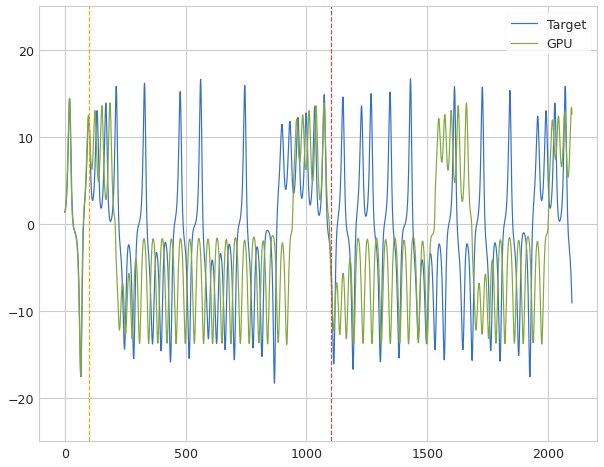

 Iter=60 a=0.312 sr=1.383 amp=0.879  ri=2.288 rr=3.170 loss=0.830516


Iter: 60 #### Diagnostic 0.830516   Time 8.27  Best 0.831 NRMSE 0.230 CD 0.600
Iter: 61 #### Diagnostic 1.368956   Time 6.59  Best 0.831 NRMSE 0.305 CD 1.064
Iter: 62 #### Diagnostic 1.274250   Time 6.65  Best 0.831 NRMSE 0.285 CD 0.989
Iter: 63 #### Diagnostic 1.391772   Time 7.53  Best 0.831 NRMSE 0.314 CD 1.078
Iter: 64 #### Diagnostic 1.381922   Time 5.80  Best 0.831 NRMSE 0.320 CD 1.062
Iter: 65 #### Diagnostic 1.387488   Time 7.71  Best 0.831 NRMSE 0.299 CD 1.089
Iter: 66 #### Diagnostic 1.057625   Time 6.75  Best 0.831 NRMSE 0.267 CD 0.790
Iter: 67 #### Diagnostic 1.481484   Time 6.53  Best 0.831 NRMSE 0.314 CD 1.167
Iter: 68 #### Diagnostic 1.207284   Time 7.79  Best 0.831 NRMSE 0.287 CD 0.921
Iter: 69 #### Diagnostic 1000.000000   Time 7.53  Best 0.831 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1.397386   Time 6.21  Best 0.831 NRMSE 0.333 CD 1.064
Iter: 71 #### Diagnostic 1.404134   Time 6.42  Best 0.83

Iter: 58 #### Diagnostic 1.404996   Time 7.49  Best 1000.000 NRMSE 0.320 CD 1.084
Iter: 59 #### Diagnostic 1.328102   Time 7.14  Best 1000.000 NRMSE 0.271 CD 1.057
Iter: 60 #### Diagnostic 1.401753   Time 7.88  Best 1000.000 NRMSE 0.337 CD 1.065
Iter: 61 #### Diagnostic 1.381514   Time 6.55  Best 1000.000 NRMSE 0.316 CD 1.066
Iter: 62 #### Diagnostic 1.405292   Time 7.21  Best 1000.000 NRMSE 0.341 CD 1.064
Iter: 63 #### Diagnostic 1.387091   Time 7.15  Best 1000.000 NRMSE 0.324 CD 1.063
Iter: 64 #### Diagnostic 1.329389   Time 7.10  Best 1000.000 NRMSE 0.271 CD 1.058
Iter: 65 #### Diagnostic 1.286662   Time 6.35  Best 1000.000 NRMSE 0.273 CD 1.013
Iter: 66 #### Diagnostic 1.371592   Time 6.99  Best 1000.000 NRMSE 0.307 CD 1.064
Iter: 67 #### Diagnostic 1.256006   Time 9.19  Best 1000.000 NRMSE 0.269 CD 0.987
Iter: 68 #### Diagnostic 1.322977   Time 7.00  Best 1000.000 NRMSE 0.287 CD 1.036
Iter: 69 #### Diagnostic 1.366399   Time 7.83  Best 1000.000 NRMSE 0.305 CD 1.062
Iter: 70 #### Di

Iter: 56 #### Diagnostic 1.368418   Time 8.03  Best 1000.000 NRMSE 0.307 CD 1.062
Iter: 57 #### Diagnostic 1.392074   Time 5.84  Best 1000.000 NRMSE 0.323 CD 1.069
Iter: 58 #### Diagnostic 1.355512   Time 7.63  Best 1000.000 NRMSE 0.294 CD 1.061
Iter: 59 #### Diagnostic 1.401289   Time 8.33  Best 1000.000 NRMSE 0.298 CD 1.103
Iter: 60 #### Diagnostic 1000.000000   Time 7.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1.131761   Time 5.90  Best 1000.000 NRMSE 0.271 CD 0.861
Iter: 62 #### Diagnostic 1.180708   Time 8.10  Best 1000.000 NRMSE 0.328 CD 0.853
Iter: 63 #### Diagnostic 1.404361   Time 5.97  Best 1000.000 NRMSE 0.339 CD 1.065
Iter: 64 #### Diagnostic 1.343390   Time 9.12  Best 1000.000 NRMSE 0.283 CD 1.060
Iter: 65 #### Diagnostic 1.365850   Time 7.34  Best 1000.000 NRMSE 0.297 CD 1.069
Iter: 66 #### Diagnostic 1.382445   Time 7.27  Best 1000.000 NRMSE 0.315 CD 1.067
Iter: 67 #### Diagnostic 1.385474   Time 6.94  Best 1000.000 NRMSE 0.320 CD 1.065
Iter: 68 ###

Iter: 54 #### Diagnostic 0.939532   Time 7.71  Best 1000.000 NRMSE 0.247 CD 0.693
Iter: 55 #### Diagnostic 1.368468   Time 7.92  Best 1000.000 NRMSE 0.297 CD 1.072
Iter: 56 #### Diagnostic 1.359904   Time 6.39  Best 1000.000 NRMSE 0.302 CD 1.058
Iter: 57 #### Diagnostic 1.376083   Time 6.61  Best 1000.000 NRMSE 0.320 CD 1.056
Iter: 58 #### Diagnostic 1.378004   Time 6.26  Best 1000.000 NRMSE 0.320 CD 1.058
Iter: 59 #### Diagnostic 1.387663   Time 6.45  Best 1000.000 NRMSE 0.324 CD 1.064
Iter: 60 #### Diagnostic 1.372274   Time 6.94  Best 1000.000 NRMSE 0.318 CD 1.054
Iter: 61 #### Diagnostic 1000.000000   Time 5.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 8.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.399340   Time 9.02  Best 1000.000 NRMSE 0.333 CD 1.066
Iter: 64 #### Diagnostic 1.338727   Time 8.96  Best 1000.000 NRMSE 0.294 CD 1.045
Iter: 65 #### Diagnostic 1.033381   Time 6.61  Best 1000.000 NRMSE 0.247 CD 0.787
Iter: 66

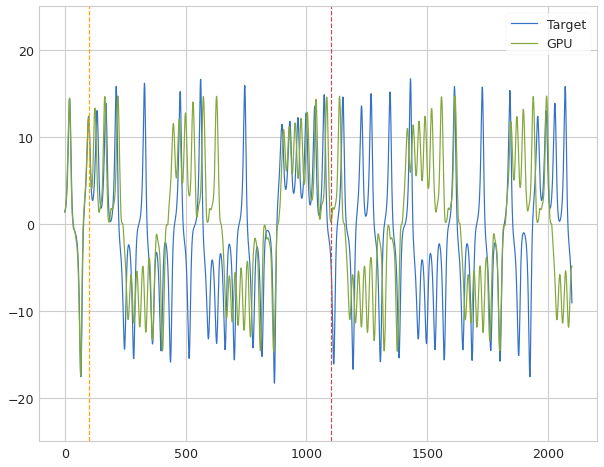

 Iter=44 a=0.287 sr=1.273 amp=0.868  ri=3.472 rr=3.548 loss=0.776673


Iter: 44 #### Diagnostic 0.776673   Time 8.41  Best 0.777 NRMSE 0.219 CD 0.558
Iter: 45 #### Diagnostic 1.215600   Time 6.89  Best 0.777 NRMSE 0.278 CD 0.937
Iter: 46 #### Diagnostic 1.085623   Time 7.53  Best 0.777 NRMSE 0.220 CD 0.866
Iter: 47 #### Diagnostic 1.048625   Time 7.49  Best 0.777 NRMSE 0.258 CD 0.791
Iter: 48 #### Diagnostic 1.335881   Time 6.99  Best 0.777 NRMSE 0.298 CD 1.038
Iter: 49 #### Diagnostic 1000.000000   Time 8.36  Best 0.777 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.344035   Time 6.49  Best 0.777 NRMSE 0.284 CD 1.060
Iter: 51 #### Diagnostic 1000.000000   Time 7.21  Best 0.777 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1.368734   Time 8.49  Best 0.777 NRMSE 0.309 CD 1.060
Iter: 53 #### Diagnostic 1.402571   Time 6.62  Best 0.777 NRMSE 0.306 CD 1.097
Iter: 54 #### Diagnostic 1.376826   Time 7.34  Best 0.777 NRMSE 0.326 CD 1.051
Iter: 55 #### Diagnostic 1.110563   Time 8.62  Best 

Iter: 36 #### Diagnostic 1.239192   Time 7.63  Best 1000.000 NRMSE 0.279 CD 0.960
Iter: 37 #### Diagnostic 1000.000000   Time 7.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1.392921   Time 7.60  Best 1000.000 NRMSE 0.332 CD 1.061
Iter: 39 #### Diagnostic 1.344004   Time 6.50  Best 1000.000 NRMSE 0.284 CD 1.060
Iter: 40 #### Diagnostic 1.395431   Time 7.72  Best 1000.000 NRMSE 0.331 CD 1.064
Iter: 41 #### Diagnostic 1.372387   Time 7.90  Best 1000.000 NRMSE 0.300 CD 1.072
Iter: 42 #### Diagnostic 1.022726   Time 6.68  Best 1000.000 NRMSE 0.254 CD 0.769
Iter: 43 #### Diagnostic 1.129303   Time 7.67  Best 1000.000 NRMSE 0.261 CD 0.868
Iter: 44 #### Diagnostic 1.376397   Time 7.59  Best 1000.000 NRMSE 0.314 CD 1.063
Iter: 45 #### Diagnostic 1.308922   Time 5.88  Best 1000.000 NRMSE 0.286 CD 1.023
Iter: 46 #### Diagnostic 1.392090   Time 6.39  Best 1000.000 NRMSE 0.306 CD 1.086
Iter: 47 #### Diagnostic 1.364002   Time 6.24  Best 1000.000 NRMSE 0.300 CD 1.064
Iter: 48 ###

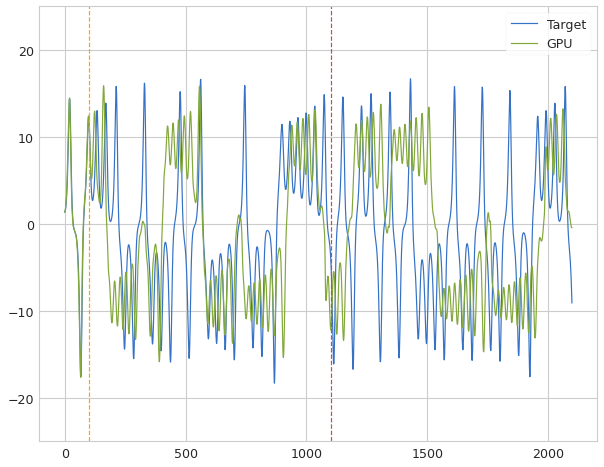

 Iter=9 a=0.337 sr=1.436 amp=0.967  ri=2.738 rr=0.754 loss=0.771465


Iter: 9 #### Diagnostic 0.771465   Time 5.98  Best 0.771 NRMSE 0.224 CD 0.547
Iter: 10 #### Diagnostic 1000.000000   Time 8.04  Best 0.771 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.364636   Time 7.55  Best 0.771 NRMSE 0.303 CD 1.061
Iter: 12 #### Diagnostic 1.382224   Time 6.33  Best 0.771 NRMSE 0.307 CD 1.076
Iter: 13 #### Diagnostic 1.139767   Time 7.67  Best 0.771 NRMSE 0.269 CD 0.871
Iter: 14 #### Diagnostic 1.287586   Time 8.06  Best 0.771 NRMSE 0.291 CD 0.997
Iter: 15 #### Diagnostic 1.216198   Time 6.09  Best 0.771 NRMSE 0.289 CD 0.927
Iter: 16 #### Diagnostic 1.311589   Time 7.21  Best 0.771 NRMSE 0.259 CD 1.052
Iter: 17 #### Diagnostic 1000.000000   Time 6.88  Best 0.771 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.330006   Time 6.77  Best 0.771 NRMSE 0.293 CD 1.037
Iter: 19 #### Diagnostic 1.450265   Time 6.93  Best 0.771 NRMSE 0.323 CD 1.127
Iter: 20 #### Diagnostic 1.415274   Time 6.55  Best 0.

Iter: 9 #### Diagnostic 1.342133   Time 6.72  Best 1000.000 NRMSE 0.282 CD 1.060
Iter: 10 #### Diagnostic 1.372599   Time 7.20  Best 1000.000 NRMSE 0.310 CD 1.063
Iter: 11 #### Diagnostic 1.005924   Time 6.55  Best 1000.000 NRMSE 0.242 CD 0.764
Iter: 12 #### Diagnostic 1.341789   Time 7.14  Best 1000.000 NRMSE 0.309 CD 1.032
Iter: 13 #### Diagnostic 1.382843   Time 7.46  Best 1000.000 NRMSE 0.324 CD 1.059
Iter: 14 #### Diagnostic 1.126469   Time 6.87  Best 1000.000 NRMSE 0.271 CD 0.856
Iter: 15 #### Diagnostic 1.358532   Time 7.58  Best 1000.000 NRMSE 0.303 CD 1.056
Iter: 16 #### Diagnostic 1.376543   Time 7.51  Best 1000.000 NRMSE 0.314 CD 1.062
Iter: 17 #### Diagnostic 1.062064   Time 6.03  Best 1000.000 NRMSE 0.254 CD 0.808
Iter: 18 #### Diagnostic 1.381094   Time 9.63  Best 1000.000 NRMSE 0.318 CD 1.063
Iter: 19 #### Diagnostic 1.318776   Time 6.51  Best 1000.000 NRMSE 0.293 CD 1.026
Iter: 20 #### Diagnostic 1.273659   Time 7.07  Best 1000.000 NRMSE 0.286 CD 0.988
Iter: 21 #### Dia

Iter: 7 #### Diagnostic 1.360237   Time 8.59  Best 1000.000 NRMSE 0.302 CD 1.058
Iter: 8 #### Diagnostic 1.377908   Time 5.35  Best 1000.000 NRMSE 0.306 CD 1.072
Iter: 9 #### Diagnostic 1.097996   Time 6.63  Best 1000.000 NRMSE 0.262 CD 0.836
Iter: 10 #### Diagnostic 1.474443   Time 7.04  Best 1000.000 NRMSE 0.312 CD 1.163
Iter: 11 #### Diagnostic 1.262416   Time 7.33  Best 1000.000 NRMSE 0.281 CD 0.981
Iter: 12 #### Diagnostic 1.373384   Time 6.00  Best 1000.000 NRMSE 0.313 CD 1.061
Iter: 13 #### Diagnostic 1.390385   Time 7.69  Best 1000.000 NRMSE 0.330 CD 1.060
Iter: 14 #### Diagnostic 1.406188   Time 6.07  Best 1000.000 NRMSE 0.342 CD 1.064
Iter: 15 #### Diagnostic 0.937382   Time 7.55  Best 1000.000 NRMSE 0.237 CD 0.701
Iter: 16 #### Diagnostic 1000.000000   Time 6.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.282775   Time 8.58  Best 1000.000 NRMSE 0.303 CD 0.980
Iter: 18 #### Diagnostic 1.376930   Time 5.99  Best 1000.000 NRMSE 0.314 CD 1.063
Iter: 19 #### D

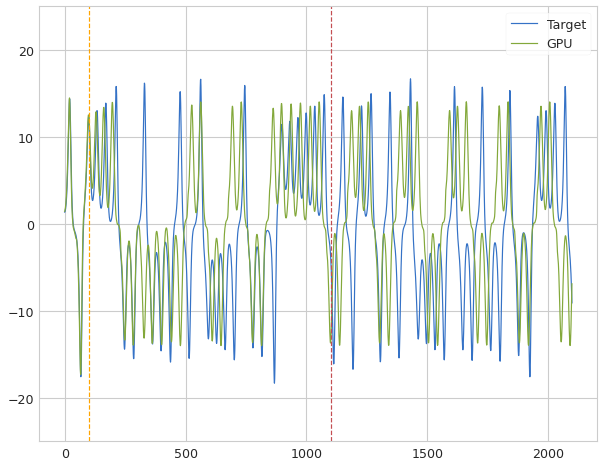

 Iter=97 a=0.275 sr=1.428 amp=0.949  ri=3.223 rr=2.492 loss=0.803608


Iter: 97 #### Diagnostic 0.803608   Time 8.01  Best 0.804 NRMSE 0.220 CD 0.584
Iter: 98 #### Diagnostic 1.381875   Time 7.29  Best 0.804 NRMSE 0.318 CD 1.064
Iter: 99 #### Diagnostic 1.403175   Time 6.78  Best 0.804 NRMSE 0.340 CD 1.063

Best result = 0.8036082264961733
a = 0.2745473894462734
sr = 1.427858012594653
amp = 0.9485676956453588
ri = 3.2226172035045657
rr = 2.491771195271502
********** Size 20 -- Run 4 ***********
Iter: 0 #### Diagnostic 1.341872   Time 6.53  Best 1000.000 NRMSE 0.283 CD 1.059
Iter: 1 #### Diagnostic 1000.000000   Time 7.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.197427   Time 8.65  Best 1000.000 NRMSE 0.279 CD 0.919
Iter: 3 #### Diagnostic 1000.000000   Time 6.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.355784   Time 5.45  Best 1000.000 NRMSE 0.293 CD 1.062
Iter: 5 #### Diagnostic 1.353433   Time 7.32  Best 1000.000 NRMSE 0.304 CD 1.049
Iter: 

Iter: 94 #### Diagnostic 1.412109   Time 7.74  Best 1000.000 NRMSE 0.340 CD 1.072
Iter: 95 #### Diagnostic 1.399649   Time 8.63  Best 1000.000 NRMSE 0.338 CD 1.061
Iter: 96 #### Diagnostic 1.472549   Time 6.24  Best 1000.000 NRMSE 0.329 CD 1.144
Iter: 97 #### Diagnostic 1.389896   Time 7.93  Best 1000.000 NRMSE 0.328 CD 1.062
Iter: 98 #### Diagnostic 1000.000000   Time 5.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1.412568   Time 7.45  Best 1000.000 NRMSE 0.344 CD 1.068

Best result = 0.9177476923124009
a = 0.3142990451765292
sr = 1.334937624241799
amp = 1.0247346492459164
ri = 1.5615574992896848
rr = 2.633402324200307

Best mn:0.275	 mn:0.337
New bounds mn--mx: 0.034--0.059

Best mn:1.428	 mn:1.436
New bounds mn--mx: 0.239--0.172

Best mn:0.949	 mn:0.967
New bounds mn--mx: 0.157--0.149

Best mn:2.738	 mn:3.223
New bounds mn--mx: 0.797--0.757

Best mn:0.754	 mn:2.492
New bounds mn--mx: -0.416--1.141
Refined search bounds:

Alpha (0.24037668480656058, 0.396749380676

Iter: 85 #### Diagnostic 1.391304   Time 7.02  Best 1000.000 NRMSE 0.328 CD 1.064
Iter: 86 #### Diagnostic 1.351872   Time 8.34  Best 1000.000 NRMSE 0.312 CD 1.040
Iter: 87 #### Diagnostic 1.376911   Time 7.19  Best 1000.000 NRMSE 0.321 CD 1.056
Iter: 88 #### Diagnostic 0.945659   Time 5.74  Best 1000.000 NRMSE 0.245 CD 0.701
Iter: 89 #### Diagnostic 1.310301   Time 5.71  Best 1000.000 NRMSE 0.286 CD 1.024
Iter: 90 #### Diagnostic 1.385458   Time 6.57  Best 1000.000 NRMSE 0.326 CD 1.060
Iter: 91 #### Diagnostic 1.362664   Time 7.81  Best 1000.000 NRMSE 0.299 CD 1.064
Iter: 92 #### Diagnostic 1.435661   Time 7.98  Best 1000.000 NRMSE 0.318 CD 1.117
Iter: 93 #### Diagnostic 1.283651   Time 8.45  Best 1000.000 NRMSE 0.287 CD 0.997
Iter: 94 #### Diagnostic 1000.000000   Time 7.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1.214990   Time 7.41  Best 1000.000 NRMSE 0.277 CD 0.938
Iter: 96 #### Diagnostic 1.202147   Time 7.03  Best 1000.000 NRMSE 0.287 CD 0.916
Iter: 97 ###

Iter: 83 #### Diagnostic 1.412179   Time 7.06  Best 1000.000 NRMSE 0.322 CD 1.090
Iter: 84 #### Diagnostic 1.248959   Time 8.43  Best 1000.000 NRMSE 0.225 CD 1.024
Iter: 85 #### Diagnostic 1.402329   Time 7.07  Best 1000.000 NRMSE 0.338 CD 1.065
Iter: 86 #### Diagnostic 1.324854   Time 7.10  Best 1000.000 NRMSE 0.268 CD 1.057
Iter: 87 #### Diagnostic 1000.000000   Time 7.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 6.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.331065   Time 5.92  Best 1000.000 NRMSE 0.273 CD 1.059
Iter: 90 #### Diagnostic 1.377691   Time 7.13  Best 1000.000 NRMSE 0.316 CD 1.062
Iter: 91 #### Diagnostic 1.331832   Time 6.28  Best 1000.000 NRMSE 0.275 CD 1.056
Iter: 92 #### Diagnostic 1.386276   Time 6.31  Best 1000.000 NRMSE 0.323 CD 1.063
Iter: 93 #### Diagnostic 1.361370   Time 5.74  Best 1000.000 NRMSE 0.299 CD 1.062
Iter: 94 #### Diagnostic 1000.000000   Time 5.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter

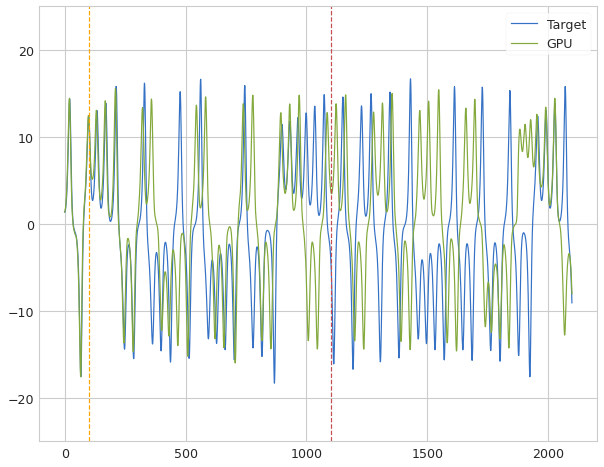

 Iter=61 a=0.298 sr=1.333 amp=0.971  ri=0.717 rr=2.797 loss=0.744171


Iter: 61 #### Diagnostic 0.744171   Time 7.75  Best 0.744 NRMSE 0.211 CD 0.533
Iter: 62 #### Diagnostic 1.390118   Time 9.18  Best 0.744 NRMSE 0.310 CD 1.080
Iter: 63 #### Diagnostic 1.329897   Time 4.78  Best 0.744 NRMSE 0.296 CD 1.034
Iter: 64 #### Diagnostic 1.266734   Time 7.74  Best 0.744 NRMSE 0.281 CD 0.986
Iter: 65 #### Diagnostic 1.183677   Time 5.86  Best 0.744 NRMSE 0.279 CD 0.905
Iter: 66 #### Diagnostic 1.184570   Time 7.40  Best 0.744 NRMSE 0.290 CD 0.895
Iter: 67 #### Diagnostic 0.879705   Time 7.72  Best 0.744 NRMSE 0.231 CD 0.649
Iter: 68 #### Diagnostic 1.226999   Time 6.78  Best 0.744 NRMSE 0.286 CD 0.941
Iter: 69 #### Diagnostic 1.315034   Time 6.03  Best 0.744 NRMSE 0.290 CD 1.025
Iter: 70 #### Diagnostic 1.403375   Time 8.03  Best 0.744 NRMSE 0.341 CD 1.063
Iter: 71 #### Diagnostic 1.183452   Time 8.19  Best 0.744 NRMSE 0.277 CD 0.907
Iter: 72 #### Diagnostic 1.275204   Time 7.67  Best 0.744 NR

Iter: 59 #### Diagnostic 1.400680   Time 7.14  Best 1000.000 NRMSE 0.300 CD 1.101
Iter: 60 #### Diagnostic 1.405300   Time 7.07  Best 1000.000 NRMSE 0.307 CD 1.099
Iter: 61 #### Diagnostic 1.365995   Time 7.59  Best 1000.000 NRMSE 0.303 CD 1.063
Iter: 62 #### Diagnostic 1000.000000   Time 7.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.385735   Time 5.67  Best 1000.000 NRMSE 0.324 CD 1.062
Iter: 64 #### Diagnostic 1.327881   Time 9.19  Best 1000.000 NRMSE 0.273 CD 1.055
Iter: 65 #### Diagnostic 1.363025   Time 8.75  Best 1000.000 NRMSE 0.301 CD 1.062
Iter: 66 #### Diagnostic 1.354205   Time 7.27  Best 1000.000 NRMSE 0.293 CD 1.061
Iter: 67 #### Diagnostic 1.393617   Time 6.53  Best 1000.000 NRMSE 0.327 CD 1.067
Iter: 68 #### Diagnostic 1.297450   Time 6.63  Best 1000.000 NRMSE 0.297 CD 1.001
Iter: 69 #### Diagnostic 1.318531   Time 7.97  Best 1000.000 NRMSE 0.295 CD 1.023
Iter: 70 #### Diagnostic 1.337156   Time 5.27  Best 1000.000 NRMSE 0.292 CD 1.045
Iter: 71 ###

Iter: 57 #### Diagnostic 1.293958   Time 5.85  Best 1000.000 NRMSE 0.290 CD 1.004
Iter: 58 #### Diagnostic 1.359069   Time 7.54  Best 1000.000 NRMSE 0.300 CD 1.059
Iter: 59 #### Diagnostic 1.390951   Time 7.36  Best 1000.000 NRMSE 0.310 CD 1.081
Iter: 60 #### Diagnostic 1.183523   Time 6.97  Best 1000.000 NRMSE 0.279 CD 0.905
Iter: 61 #### Diagnostic 1.390964   Time 7.57  Best 1000.000 NRMSE 0.326 CD 1.065
Iter: 62 #### Diagnostic 1.506655   Time 7.76  Best 1000.000 NRMSE 0.424 CD 1.083
Iter: 63 #### Diagnostic 1.291311   Time 7.10  Best 1000.000 NRMSE 0.292 CD 0.999
Iter: 64 #### Diagnostic 1.351773   Time 7.35  Best 1000.000 NRMSE 0.308 CD 1.043
Iter: 65 #### Diagnostic 1.030086   Time 6.78  Best 1000.000 NRMSE 0.208 CD 0.822
Iter: 66 #### Diagnostic 1.075073   Time 6.62  Best 1000.000 NRMSE 0.259 CD 0.816
Iter: 67 #### Diagnostic 1000.000000   Time 5.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1.380934   Time 7.43  Best 1000.000 NRMSE 0.317 CD 1.064
Iter: 69 ###

Iter: 48 #### Diagnostic 1.396736   Time 5.73  Best 1000.000 NRMSE 0.322 CD 1.075
Iter: 49 #### Diagnostic 1.390783   Time 7.78  Best 1000.000 NRMSE 0.323 CD 1.068
Iter: 50 #### Diagnostic 1.256763   Time 7.29  Best 1000.000 NRMSE 0.279 CD 0.978
Iter: 51 #### Diagnostic 0.897983   Time 6.94  Best 1000.000 NRMSE 0.199 CD 0.699
Iter: 52 #### Diagnostic 1.327695   Time 7.02  Best 1000.000 NRMSE 0.272 CD 1.056
Iter: 53 #### Diagnostic 1.349236   Time 7.17  Best 1000.000 NRMSE 0.307 CD 1.042
Iter: 54 #### Diagnostic 1.395881   Time 7.48  Best 1000.000 NRMSE 0.332 CD 1.064
Iter: 55 #### Diagnostic 1.383779   Time 6.66  Best 1000.000 NRMSE 0.321 CD 1.063
Iter: 56 #### Diagnostic 1.347973   Time 6.11  Best 1000.000 NRMSE 0.287 CD 1.060
Iter: 57 #### Diagnostic 1.387133   Time 8.05  Best 1000.000 NRMSE 0.332 CD 1.055
Iter: 58 #### Diagnostic 1.365980   Time 6.18  Best 1000.000 NRMSE 0.298 CD 1.068
Iter: 59 #### Diagnostic 1.362763   Time 6.74  Best 1000.000 NRMSE 0.301 CD 1.061
Iter: 60 #### Di

Iter: 46 #### Diagnostic 1.380550   Time 7.65  Best 1000.000 NRMSE 0.311 CD 1.070
Iter: 47 #### Diagnostic 1.388026   Time 6.27  Best 1000.000 NRMSE 0.324 CD 1.064
Iter: 48 #### Diagnostic 1000.000000   Time 5.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.228606   Time 5.81  Best 1000.000 NRMSE 0.277 CD 0.952
Iter: 50 #### Diagnostic 1.394907   Time 6.25  Best 1000.000 NRMSE 0.326 CD 1.069
Iter: 51 #### Diagnostic 1.392404   Time 7.56  Best 1000.000 NRMSE 0.327 CD 1.065
Iter: 52 #### Diagnostic 1.487974   Time 7.73  Best 1000.000 NRMSE 0.310 CD 1.178
Iter: 53 #### Diagnostic 1.123417   Time 7.85  Best 1000.000 NRMSE 0.264 CD 0.859
Iter: 54 #### Diagnostic 1.310570   Time 6.42  Best 1000.000 NRMSE 0.257 CD 1.053
Iter: 55 #### Diagnostic 1.374224   Time 6.29  Best 1000.000 NRMSE 0.316 CD 1.059
Iter: 56 #### Diagnostic 1.353676   Time 7.22  Best 1000.000 NRMSE 0.293 CD 1.061
Iter: 57 #### Diagnostic 1.405463   Time 5.99  Best 1000.000 NRMSE 0.341 CD 1.065
Iter: 58 ###

Iter: 44 #### Diagnostic 1.359508   Time 5.63  Best 1000.000 NRMSE 0.298 CD 1.061
Iter: 45 #### Diagnostic 1.363752   Time 7.01  Best 1000.000 NRMSE 0.302 CD 1.062
Iter: 46 #### Diagnostic 1.362209   Time 7.26  Best 1000.000 NRMSE 0.301 CD 1.061
Iter: 47 #### Diagnostic 1.094098   Time 5.81  Best 1000.000 NRMSE 0.269 CD 0.826
Iter: 48 #### Diagnostic 1.102488   Time 7.20  Best 1000.000 NRMSE 0.250 CD 0.853
Iter: 49 #### Diagnostic 1.365179   Time 6.41  Best 1000.000 NRMSE 0.303 CD 1.062
Iter: 50 #### Diagnostic 1.371642   Time 5.30  Best 1000.000 NRMSE 0.308 CD 1.064
Iter: 51 #### Diagnostic 1.401943   Time 5.71  Best 1000.000 NRMSE 0.299 CD 1.102
Iter: 52 #### Diagnostic 1.396108   Time 6.49  Best 1000.000 NRMSE 0.323 CD 1.073
Iter: 53 #### Diagnostic 1.314767   Time 6.62  Best 1000.000 NRMSE 0.277 CD 1.038
Iter: 54 #### Diagnostic 1.391305   Time 6.83  Best 1000.000 NRMSE 0.328 CD 1.063
Iter: 55 #### Diagnostic 1.228855   Time 7.88  Best 1000.000 NRMSE 0.278 CD 0.951
Iter: 56 #### Di

Iter: 42 #### Diagnostic 1.038353   Time 7.08  Best 1000.000 NRMSE 0.261 CD 0.777
Iter: 43 #### Diagnostic 1.377609   Time 6.30  Best 1000.000 NRMSE 0.315 CD 1.062
Iter: 44 #### Diagnostic 1.355661   Time 7.33  Best 1000.000 NRMSE 0.295 CD 1.061
Iter: 45 #### Diagnostic 1.391572   Time 6.58  Best 1000.000 NRMSE 0.328 CD 1.064
Iter: 46 #### Diagnostic 1.357850   Time 7.74  Best 1000.000 NRMSE 0.298 CD 1.059
Iter: 47 #### Diagnostic 1.195142   Time 8.42  Best 1000.000 NRMSE 0.320 CD 0.875
Iter: 48 #### Diagnostic 1.401026   Time 5.53  Best 1000.000 NRMSE 0.336 CD 1.065
Iter: 49 #### Diagnostic 1.394555   Time 5.57  Best 1000.000 NRMSE 0.330 CD 1.065
Iter: 50 #### Diagnostic 1.391268   Time 7.68  Best 1000.000 NRMSE 0.329 CD 1.062
Iter: 51 #### Diagnostic 1.388808   Time 7.42  Best 1000.000 NRMSE 0.326 CD 1.063
Iter: 52 #### Diagnostic 1000.000000   Time 5.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 7.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54

Iter: 39 #### Diagnostic 1000.000000   Time 5.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.350334   Time 5.83  Best 1000.000 NRMSE 0.298 CD 1.052
Iter: 41 #### Diagnostic 1.343029   Time 6.64  Best 1000.000 NRMSE 0.283 CD 1.060
Iter: 42 #### Diagnostic 1.375074   Time 6.30  Best 1000.000 NRMSE 0.314 CD 1.062
Iter: 43 #### Diagnostic 1.268346   Time 8.01  Best 1000.000 NRMSE 0.270 CD 0.998
Iter: 44 #### Diagnostic 1.371966   Time 6.66  Best 1000.000 NRMSE 0.303 CD 1.069
Iter: 45 #### Diagnostic 1.292079   Time 7.76  Best 1000.000 NRMSE 0.297 CD 0.995
Iter: 46 #### Diagnostic 1.280243   Time 8.03  Best 1000.000 NRMSE 0.275 CD 1.006
Iter: 47 #### Diagnostic 1.436838   Time 6.60  Best 1000.000 NRMSE 0.308 CD 1.129
Iter: 48 #### Diagnostic 1.441632   Time 6.74  Best 1000.000 NRMSE 0.328 CD 1.114
Iter: 49 #### Diagnostic 1000.000000   Time 7.32  Best 1000.000 NRMSE 1000.000 CD nan


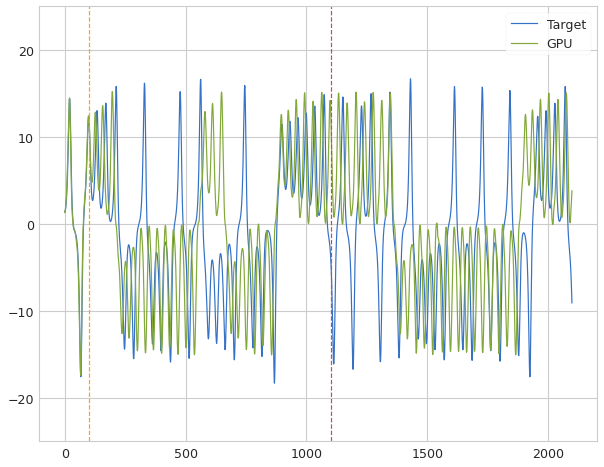

 Iter=50 a=0.280 sr=1.251 amp=0.916  ri=3.673 rr=0.179 loss=0.848498


Iter: 50 #### Diagnostic 0.848498   Time 7.79  Best 0.848 NRMSE 0.234 CD 0.614
Iter: 51 #### Diagnostic 1.389503   Time 6.62  Best 0.848 NRMSE 0.325 CD 1.064
Iter: 52 #### Diagnostic 1.348234   Time 7.49  Best 0.848 NRMSE 0.298 CD 1.050
Iter: 53 #### Diagnostic 1.396404   Time 7.84  Best 0.848 NRMSE 0.337 CD 1.059
Iter: 54 #### Diagnostic 1.414539   Time 6.22  Best 0.848 NRMSE 0.347 CD 1.068
Iter: 55 #### Diagnostic 1.584681   Time 6.62  Best 0.848 NRMSE 0.316 CD 1.269
Iter: 56 #### Diagnostic 1.398635   Time 8.23  Best 0.848 NRMSE 0.324 CD 1.075
Iter: 57 #### Diagnostic 1.357684   Time 5.87  Best 0.848 NRMSE 0.296 CD 1.062
Iter: 58 #### Diagnostic 1.402786   Time 6.99  Best 0.848 NRMSE 0.328 CD 1.075
Iter: 59 #### Diagnostic 1.004873   Time 6.31  Best 0.848 NRMSE 0.249 CD 0.756
Iter: 60 #### Diagnostic 1.147595   Time 5.21  Best 0.848 NRMSE 0.266 CD 0.881
Iter: 61 #### Diagnostic 1.378829   Time 6.71  Best 0.848 NR

Iter: 42 #### Diagnostic 1.383718   Time 5.96  Best 1000.000 NRMSE 0.320 CD 1.064
Iter: 43 #### Diagnostic 1.322713   Time 7.36  Best 1000.000 NRMSE 0.266 CD 1.056
Iter: 44 #### Diagnostic 1.404440   Time 5.29  Best 1000.000 NRMSE 0.340 CD 1.065
Iter: 45 #### Diagnostic 1.261548   Time 7.74  Best 1000.000 NRMSE 0.237 CD 1.025
Iter: 46 #### Diagnostic 1.366177   Time 7.90  Best 1000.000 NRMSE 0.304 CD 1.062
Iter: 47 #### Diagnostic 1.348535   Time 5.09  Best 1000.000 NRMSE 0.288 CD 1.061
Iter: 48 #### Diagnostic 1.323388   Time 5.34  Best 1000.000 NRMSE 0.268 CD 1.055
Iter: 49 #### Diagnostic 1.350248   Time 7.11  Best 1000.000 NRMSE 0.296 CD 1.054
Iter: 50 #### Diagnostic 1.349423   Time 6.06  Best 1000.000 NRMSE 0.289 CD 1.060
Iter: 51 #### Diagnostic 1.329091   Time 7.63  Best 1000.000 NRMSE 0.272 CD 1.057
Iter: 52 #### Diagnostic 1.330768   Time 6.99  Best 1000.000 NRMSE 0.273 CD 1.058
Iter: 53 #### Diagnostic 1.356730   Time 5.59  Best 1000.000 NRMSE 0.296 CD 1.061
Iter: 54 #### Di

Iter: 40 #### Diagnostic 1.294082   Time 7.11  Best 1000.000 NRMSE 0.248 CD 1.046
Iter: 41 #### Diagnostic 1.315573   Time 7.62  Best 1000.000 NRMSE 0.237 CD 1.079
Iter: 42 #### Diagnostic 1.354024   Time 5.34  Best 1000.000 NRMSE 0.297 CD 1.057
Iter: 43 #### Diagnostic 1.309621   Time 7.48  Best 1000.000 NRMSE 0.259 CD 1.051
Iter: 44 #### Diagnostic 1.096306   Time 7.86  Best 1000.000 NRMSE 0.270 CD 0.827
Iter: 45 #### Diagnostic 1.302245   Time 6.83  Best 1000.000 NRMSE 0.253 CD 1.049
Iter: 46 #### Diagnostic 1.365106   Time 7.34  Best 1000.000 NRMSE 0.301 CD 1.065
Iter: 47 #### Diagnostic 1.329556   Time 6.86  Best 1000.000 NRMSE 0.294 CD 1.036
Iter: 48 #### Diagnostic 1.407690   Time 7.63  Best 1000.000 NRMSE 0.294 CD 1.113
Iter: 49 #### Diagnostic 1.304625   Time 7.71  Best 1000.000 NRMSE 0.253 CD 1.052
Iter: 50 #### Diagnostic 1.330405   Time 6.21  Best 1000.000 NRMSE 0.274 CD 1.057
Iter: 51 #### Diagnostic 1.241819   Time 5.89  Best 1000.000 NRMSE 0.226 CD 1.016
Iter: 52 #### Di

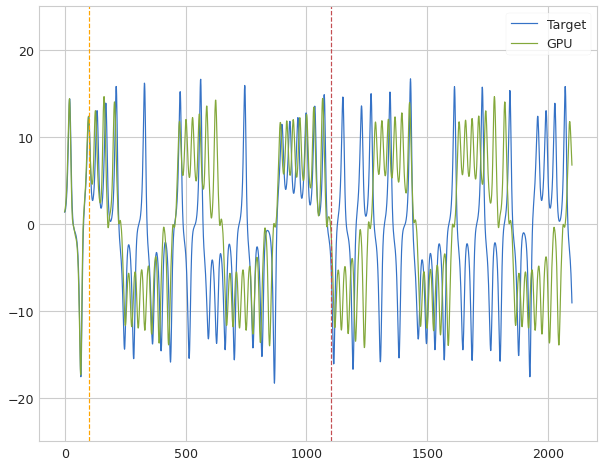

 Iter=63 a=0.285 sr=1.403 amp=0.810  ri=3.511 rr=3.071 loss=0.723786


Iter: 63 #### Diagnostic 0.723786   Time 5.65  Best 0.724 NRMSE 0.212 CD 0.512
Iter: 64 #### Diagnostic 1.317698   Time 6.83  Best 0.724 NRMSE 0.263 CD 1.055
Iter: 65 #### Diagnostic 1.338912   Time 5.64  Best 0.724 NRMSE 0.279 CD 1.060
Iter: 66 #### Diagnostic 1.417797   Time 6.32  Best 0.724 NRMSE 0.300 CD 1.118
Iter: 67 #### Diagnostic 1.346823   Time 7.70  Best 0.724 NRMSE 0.286 CD 1.060
Iter: 68 #### Diagnostic 1.354329   Time 6.98  Best 0.724 NRMSE 0.292 CD 1.062
Iter: 69 #### Diagnostic 1.376460   Time 6.02  Best 0.724 NRMSE 0.311 CD 1.066
Iter: 70 #### Diagnostic 1.322569   Time 6.80  Best 0.724 NRMSE 0.275 CD 1.048
Iter: 71 #### Diagnostic 1.244118   Time 6.79  Best 0.724 NRMSE 0.274 CD 0.970
Iter: 72 #### Diagnostic 1.237742   Time 6.37  Best 0.724 NRMSE 0.238 CD 1.000
Iter: 73 #### Diagnostic 1.410792   Time 6.30  Best 0.724 NRMSE 0.348 CD 1.063
Iter: 74 #### Diagnostic 1.331179   Time 7.00  Best 0.724 NR

Iter: 62 #### Diagnostic 1.334397   Time 6.33  Best 1000.000 NRMSE 0.277 CD 1.057
Iter: 63 #### Diagnostic 1.357816   Time 6.08  Best 1000.000 NRMSE 0.296 CD 1.062
Iter: 64 #### Diagnostic 1.399136   Time 6.76  Best 1000.000 NRMSE 0.339 CD 1.060
Iter: 65 #### Diagnostic 1.343564   Time 6.01  Best 1000.000 NRMSE 0.284 CD 1.060
Iter: 66 #### Diagnostic 1.312301   Time 5.63  Best 1000.000 NRMSE 0.259 CD 1.054
Iter: 67 #### Diagnostic 1.296425   Time 7.47  Best 1000.000 NRMSE 0.295 CD 1.001
Iter: 68 #### Diagnostic 1.396602   Time 6.41  Best 1000.000 NRMSE 0.333 CD 1.064
Iter: 69 #### Diagnostic 1.291837   Time 5.38  Best 1000.000 NRMSE 0.247 CD 1.045
Iter: 70 #### Diagnostic 1000.000000   Time 5.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.389030   Time 6.17  Best 1000.000 NRMSE 0.316 CD 1.073
Iter: 72 #### Diagnostic 1.324178   Time 7.06  Best 1000.000 NRMSE 0.267 CD 1.057
Iter: 73 #### Diagnostic 1.466655   Time 7.89  Best 1000.000 NRMSE 0.330 CD 1.137
Iter: 74 ###

Iter: 60 #### Diagnostic 1.358411   Time 8.70  Best 1000.000 NRMSE 0.295 CD 1.063
Iter: 61 #### Diagnostic 1.384755   Time 6.76  Best 1000.000 NRMSE 0.316 CD 1.068
Iter: 62 #### Diagnostic 1000.000000   Time 5.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.307453   Time 7.10  Best 1000.000 NRMSE 0.288 CD 1.019
Iter: 64 #### Diagnostic 1.340639   Time 6.62  Best 1000.000 NRMSE 0.284 CD 1.057
Iter: 65 #### Diagnostic 1.363735   Time 6.63  Best 1000.000 NRMSE 0.303 CD 1.061
Iter: 66 #### Diagnostic 1.387769   Time 7.14  Best 1000.000 NRMSE 0.308 CD 1.080
Iter: 67 #### Diagnostic 1.346881   Time 5.31  Best 1000.000 NRMSE 0.288 CD 1.059
Iter: 68 #### Diagnostic 1.307638   Time 6.72  Best 1000.000 NRMSE 0.296 CD 1.012
Iter: 69 #### Diagnostic 1.308487   Time 6.93  Best 1000.000 NRMSE 0.258 CD 1.050
Iter: 70 #### Diagnostic 1.567895   Time 5.91  Best 1000.000 NRMSE 0.322 CD 1.246
Iter: 71 #### Diagnostic 1.362159   Time 6.19  Best 1000.000 NRMSE 0.305 CD 1.057
Iter: 72 ###

Iter: 58 #### Diagnostic 1.375199   Time 4.69  Best 1000.000 NRMSE 0.312 CD 1.063
Iter: 59 #### Diagnostic 1.366020   Time 5.21  Best 1000.000 NRMSE 0.304 CD 1.062
Iter: 60 #### Diagnostic 1.369754   Time 6.05  Best 1000.000 NRMSE 0.308 CD 1.062
Iter: 61 #### Diagnostic 1.329907   Time 5.37  Best 1000.000 NRMSE 0.271 CD 1.059
Iter: 62 #### Diagnostic 1.395382   Time 6.23  Best 1000.000 NRMSE 0.325 CD 1.071
Iter: 63 #### Diagnostic 1.277549   Time 6.72  Best 1000.000 NRMSE 0.245 CD 1.032
Iter: 64 #### Diagnostic 1.373583   Time 5.36  Best 1000.000 NRMSE 0.305 CD 1.069
Iter: 65 #### Diagnostic 1.362888   Time 8.66  Best 1000.000 NRMSE 0.302 CD 1.061
Iter: 66 #### Diagnostic 1.316508   Time 6.41  Best 1000.000 NRMSE 0.263 CD 1.054
Iter: 67 #### Diagnostic 1.309786   Time 7.24  Best 1000.000 NRMSE 0.258 CD 1.052
Iter: 68 #### Diagnostic 1.694832   Time 7.25  Best 1000.000 NRMSE 0.353 CD 1.342
Iter: 69 #### Diagnostic 1.345138   Time 6.56  Best 1000.000 NRMSE 0.302 CD 1.043
Iter: 70 #### Di

In [ ]:
CALLS = 100
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)
# Skipped 1000, 900
size = [40,30,20,10]
rand_state = [11,37,3,24,91]

for N in size:
    min_a, max_a = .25, .4
    min_sr, max_sr = 1.25, 1.45
    min_g, max_g = .8, 1.1
    min_ri, max_ri = .001, 4.
    min_rr, max_rr = .001, 4.
    space = [Real(min_a, max_a, name='a'),
                     Real(min_sr, max_sr, name='sr'),
                     Real(min_g, max_g, name='amp'), 
                     Real(min_ri, max_ri, name='ri'),
                     Real(min_rr, max_rr, name='rr')
                    ]
    for ref in range(5):
        start = time.time()
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []
        
        for rn in range(5):
            running_error = 1000
            counter = 0 
            print(f'********** Size {N} -- Run {rn} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=-1,
                                    n_initial_points=100)
            print(f'\nBest result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')
                
        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        end = time.time()-start
        print(f'End Refinement Run {ref} Time {end:.3f}')